In [1]:
import json
import matplotlib.pyplot as plt
import torch

import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import os
from torchvision.io import read_image
from PIL import Image

import numpy as np
import matplotlib.patches as patches
from torchvision import transforms

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torchmetrics.detection.map import MeanAveragePrecision

In [2]:
import pycocotools

In [3]:
# imports from local lib files
import utils
import transforms
import coco_eval
from engine import train_one_epoch, evaluate

Example of data in annotation files

In [4]:
output_path = 'output'
img_folder = 'eccv_18_all_images_sm'

cis_test_ann_path = 'eccv_18_annotation_files/cis_test_annotations.json'
cis_val_ann_path = 'eccv_18_annotation_files/cis_val_annotations.json'
train_ann_path = 'eccv_18_annotation_files/train_annotations.json'
trans_test_ann_path = 'eccv_18_annotation_files/trans_test_annotations.json'
trans_val_ann_path = 'eccv_18_annotation_files/trans_val_annotations.json'

Number of images per split

In [5]:
cis_test_ann = json.load(open(cis_test_ann_path))
cis_val_ann = json.load(open(cis_val_ann_path))
train_ann= json.load(open(train_ann_path))
trans_test_ann = json.load(open(trans_test_ann_path))
trans_val_ann = json.load(open(trans_val_ann_path))

In [6]:
print(len(cis_test_ann['images']))
print(len(cis_val_ann['images']))
print(len(train_ann['images']))
print(len(trans_test_ann['images']))
print(len(trans_val_ann['images']))

15827
3484
13553
23275
1725


In [7]:
trans_val_ann.keys()

dict_keys(['info', 'categories', 'images', 'annotations'])

In [8]:
trans_val_ann['info']

{'contributor': 'Sara Beery',
 'date_created': '2018-07-03 18:34:36.573636',
 'version': 'Caltech Camera Traps - ECCV18',
 'description': 'Database of camera trap images collected from the NPS and the USGS with help from Justin Brown and Erin Boydston',
 'year': 2018}

In [9]:
trans_val_ann['categories']

[{'id': 6, 'name': 'bobcat'},
 {'id': 1, 'name': 'opossum'},
 {'id': 30, 'name': 'empty'},
 {'id': 9, 'name': 'coyote'},
 {'id': 3, 'name': 'raccoon'},
 {'id': 11, 'name': 'bird'},
 {'id': 8, 'name': 'dog'},
 {'id': 16, 'name': 'cat'},
 {'id': 5, 'name': 'squirrel'},
 {'id': 10, 'name': 'rabbit'},
 {'id': 7, 'name': 'skunk'},
 {'id': 99, 'name': 'rodent'},
 {'id': 21, 'name': 'badger'},
 {'id': 34, 'name': 'deer'},
 {'id': 33, 'name': 'car'},
 {'id': 51, 'name': 'fox'}]

In [10]:
trans_val_ann['annotations'][0]

{'image_id': '58df680b-23d2-11e8-a6a3-ec086b02610b',
 'category_id': 6,
 'bbox': [1123.7375892857142,
  787.8743750000001,
  284.6749107142857,
  244.2854464285715],
 'id': '19220'}

## Horizontal flip debugging

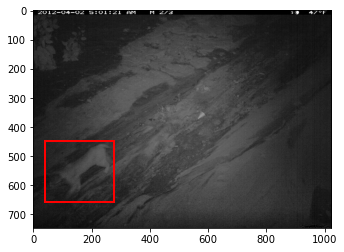

In [11]:
i = 500

boxes = [trans_val_ann['annotations'][j]['bbox'] for j in range(len(trans_val_ann['annotations'])) 
         if trans_val_ann['annotations'][j]['image_id']==trans_val_ann['images'][i]['id'] 
         and 'bbox' in trans_val_ann['annotations'][j].keys()]

img_path = os.path.join('eccv_18_all_images_sm', trans_val_ann['images'][i]['file_name']) # to change

image = read_image(img_path)

fig, ax = plt.subplots()
ax.imshow(image[0].squeeze(),cmap="gray")

scale_x = image.shape[2] / trans_val_ann['images'][i]['width'] 
scale_y = image.shape[1] / trans_val_ann['images'][i]['height']

boxes = torch.as_tensor(boxes)

for i in range(boxes.shape[0]):
    boxes[i][0] = torch.round(boxes[i][0] * scale_x)
    boxes[i][1] = torch.round(boxes[i][1] * scale_y)
    boxes[i][2] = torch.round(boxes[i][2] * scale_x)
    boxes[i][3] = torch.round(boxes[i][3] * scale_y)

    boxes[i][2] = boxes[i][0] + boxes[i][2]
    boxes[i][3] = boxes[i][1] + boxes[i][3]

target = {}
target["boxes"] = boxes

rect = patches.Rectangle((boxes[0][0], boxes[0][1]), boxes[0][2]-boxes[0][0], 
                         boxes[0][3]-boxes[0][1], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)

In [12]:
image = Image.open(img_path).convert("RGB")
#image=conv(image)

In [13]:
image.size

(1024, 747)

In [14]:
conv = torchvision.transforms.ToTensor()

In [15]:
width, height = image.size[0], image.size[1]

In [16]:
width

1024

In [17]:
height

747

In [18]:
image_new = conv(image)

In [19]:
print(image_new.shape)

torch.Size([3, 747, 1024])


## Utils

In [21]:
# In paper :  ' ... and employ horizontal flipping for data augmentation. ( for detection)

import transforms as T   # from git hub repo

data_transform = {'train': T.RandomHorizontalFlip(0.5)}

In [22]:
def get_img_with_bbox(file_path):
  
    # returns a list with the idx of images with at least one bounding box (img_wbbox) and a list with the number of bbox for each valid image (num_bbox)
    file = json.load(open(file_path))
    img_wbbox=[]
    num_bbox=[]

    for i in range(len(file['images'])):
        bboxes= [file['annotations'][j]['bbox'] for j in range(len(file['annotations'])) if file['annotations'][j]['image_id']==file['images'][i]['id'] and 'bbox' in file['annotations'][j].keys()]

        if len(bboxes)!=0:
            img_wbbox.append(i)

            num_bbox.append(len(bboxes))

    return img_wbbox, num_bbox

In [23]:
class CustomImageDataset(Dataset):
    def __init__(self, label_path, img_dir, valid_img, transform= None, target_transform=None):
        self.label_file = json.load(open(label_path))
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.valid_img= valid_img

    def __len__(self):
        return len(self.valid_img)

    def __getitem__(self, idx):
        
        idx=self.valid_img[idx] # consider only images with bbox annotations
        img_path = os.path.join(self.img_dir, self.label_file['images'][idx]['file_name'])
        image = read_image(img_path)

        conv=torchvision.transforms.ToTensor()
        #if image.shape[0]==1:
        # some images have only one channel, we convert them to rgb
        image = Image.open(img_path).convert("RGB")
        image=conv(image)

        boxes= [self.label_file['annotations'][j]['bbox'] for j in range(len(self.label_file['annotations'])) if self.label_file['annotations'][j]['image_id']==self.label_file['images'][idx]['id']]
        label= [self.label_file['annotations'][j]['category_id'] for j in range(len(self.label_file['annotations'])) if self.label_file['annotations'][j]['image_id']==self.label_file['images'][idx]['id']]

        # transform bbox coords to adjust for resizing
        scale_x=image.shape[2]/self.label_file['images'][idx]['width'] 
        scale_y=image.shape[1]/self.label_file['images'][idx]['height']

        boxes=torch.as_tensor(boxes)
        for i in range(boxes.shape[0]):
            boxes[i][0]=torch.round(boxes[i][0]*scale_x)
            boxes[i][1]=torch.round(boxes[i][1]*scale_y)
            boxes[i][2]=torch.round(boxes[i][2]*scale_x)
            boxes[i][3]=torch.round(boxes[i][3]*scale_y)

            boxes[i][2]=boxes[i][0]+boxes[i][2] # to transform to pytorch bbox format
            boxes[i][3]=boxes[i][1]+boxes[i][3]

            #boxes[i][0]*=scale_x
            #boxes[i][1]*=scale_y
            #boxes[i][2]*=scale_x
            #boxes[i][3]*=scale_y

        label=torch.as_tensor(label)
        label=torch.where(label==30,0,1)  # 0 if empty (categ id = 30), 1 if animal
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = label
        target["image_id"] = image_id
        target['area']=area
        target['iscrowd']=iscrowd

        # TO DO : resize all to same size

        if self.transform:
            # transform image AND target
            image, target = self.transform(image, target)
        if self.target_transform:
            label = self.target_transform(label)

        return image, target


Example of use

In [24]:
# get the images bounding boxes *takes about 25sec*
train_valid_img,_ = get_img_with_bbox(train_ann_path)
cis_val_valid_img,_ = get_img_with_bbox(cis_val_ann_path)

In [25]:
training_data = CustomImageDataset(train_ann_path, img_folder, train_valid_img)
valid_data = CustomImageDataset(cis_val_ann_path, img_folder, cis_val_valid_img)

train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True, collate_fn=utils.collate_fn)

# In paper : ' We use a batch size of 1'

Target (Bbox) batch shape: torch.Size([1, 4])
Target (category) batch shape: torch.Size([1])
Label: animal


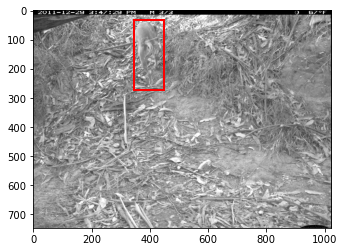

In [45]:
train_features, train_labels = next(iter(train_dataloader))
#print(f"Feature batch shape: {train_features.size()}")
print(f"Target (Bbox) batch shape: {train_labels[0]['boxes'].size()}")
print(f"Target (category) batch shape: {train_labels[0]['labels'].size()}")

img = train_features[0][0].squeeze()
label = train_labels[0]['labels']
label_categ='animal'

if label[0]==0:
    label_categ='background'

fig, ax = plt.subplots()
ax.imshow(img,cmap="gray")
rect = patches.Rectangle((train_labels[0]['boxes'][0][0], train_labels[0]['boxes'][0][1]), train_labels[0]['boxes'][0][2]-train_labels[0]['boxes'][0][0], train_labels[0]['boxes'][0][3]-train_labels[0]['boxes'][0][1], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
print(f"Label: {label_categ}")

## Horizontal flip debugging p2

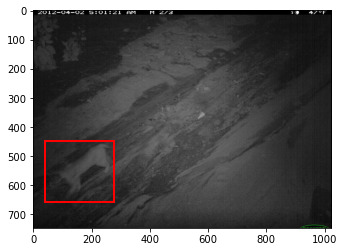

In [44]:
trans = data_transform['train']
img2, target2 = trans(image, target)

fig, ax = plt.subplots()
ax.imshow(img2, cmap="gray")

rect = patches.Rectangle((target2['boxes'][0][0], target2['boxes'][0][1]), 
                         target2['boxes'][0][2] - target2['boxes'][0][0], 
                         target2['boxes'][0][3] - target2['boxes'][0][1], 
                         linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)

## Pre-trained model

In [ ]:
# Inspired from https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/torchvision_finetuning_instance_segmentation.ipynb#scrollTo=YjNHjVMOyYlH

In [27]:
def get_model_from_pretrained(num_classes):

    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    for param in model.parameters(): # to freeze all existing weights
        param.requires_grad = False

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [28]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_model_from_pretrained(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0003, momentum=0.9)

# like in the paper
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[5,10], gamma=0.1)

In [29]:
# train_valid_img,_ = get_img_with_bbox(train_ann_path)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True, collate_fn=utils.collate_fn)

In [30]:
trans_val_valid_img,_ = get_img_with_bbox(trans_val_ann_path)   # takes about 1min to run on train data
trans_valid_data = CustomImageDataset(trans_val_ann_path,img_folder, trans_val_valid_img)
trans_valid_dataloader = DataLoader(trans_valid_data, batch_size=10, shuffle=True, collate_fn=utils.collate_fn)

In [31]:
cis_val_valid_img,_ = get_img_with_bbox(cis_val_ann_path)   # takes about 1min to run on train data
cis_valid_data = CustomImageDataset(cis_val_ann_path,img_folder, cis_val_valid_img)
cis_valid_dataloader = DataLoader(cis_valid_data, batch_size=10, shuffle=True, collate_fn=utils.collate_fn)

In [32]:
# !!TO DO : replace this 'return coco_evaluator' by this 'return metric_logger' on line 
# #109 of engine.py in evaluate function and CTRL+S

In [33]:
# way around weird behav
# del evaluate
# from engine_modif import train_one_epoch, evaluate

In [34]:
# TRAIN

all_train_logs = []
all_trans_valid_logs = []
all_cis_valid_logs = []

num_epochs = 20

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_logs = train_one_epoch(model, optimizer, train_dataloader, device, epoch, print_freq=100)
    all_train_logs.append(train_logs)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset

    for images, targets in trans_valid_dataloader: # can do batch of 10 prob.
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            trans_loss_dict = model(images, targets)
            trans_loss_dict = [{k: loss.to('cpu')} for k, loss in trans_loss_dict.items()]
            all_trans_valid_logs.append(trans_loss_dict)


    for images, targets in cis_valid_dataloader: # can do batch of 10 prob.
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            cis_loss_dict = model(images, targets)
            cis_loss_dict = [{k: loss.to('cpu')} for k, loss in cis_loss_dict.items()]
            all_cis_valid_logs.append(cis_loss_dict)

C:\Users\kevin\miniconda3\envs\animals\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [    0/12099]  eta: 7:41:49  lr: 0.000001  loss: 1.0190 (1.0190)  loss_classifier: 0.8890 (0.8890)  loss_box_reg: 0.1273 (0.1273)  loss_objectness: 0.0013 (0.0013)  loss_rpn_box_reg: 0.0014 (0.0014)  time: 2.2902  data: 0.0380  max mem: 524
Epoch: [0]  [  100/12099]  eta: 0:28:20  lr: 0.000031  loss: 0.3685 (0.7021)  loss_classifier: 0.2101 (0.5354)  loss_box_reg: 0.1411 (0.1336)  loss_objectness: 0.0093 (0.0269)  loss_rpn_box_reg: 0.0029 (0.0062)  time: 0.1166  data: 0.0337  max mem: 524
Epoch: [0]  [  200/12099]  eta: 0:25:18  lr: 0.000061  loss: 0.2666 (0.4957)  loss_classifier: 0.0966 (0.3309)  loss_box_reg: 0.0924 (0.1269)  loss_objectness: 0.0129 (0.0308)  loss_rpn_box_reg: 0.0039 (0.0071)  time: 0.1121  data: 0.0294  max mem: 524
Epoch: [0]  [  300/12099]  eta: 0:24:11  lr: 0.000091  loss: 0.2557 (0.4133)  loss_classifier: 0.0930 (0.2524)  loss_box_reg: 0.0918 (0.1206)  loss_objectness: 0.0257 (0.0325)  loss_rpn_box_reg: 0.0048 (0.0077)  time: 0.1169  data: 0.0327  m

Epoch: [0]  [ 3300/12099]  eta: 0:16:33  lr: 0.000300  loss: 0.1201 (0.1978)  loss_classifier: 0.0434 (0.0767)  loss_box_reg: 0.0593 (0.0788)  loss_objectness: 0.0133 (0.0340)  loss_rpn_box_reg: 0.0022 (0.0082)  time: 0.1105  data: 0.0289  max mem: 524
Epoch: [0]  [ 3400/12099]  eta: 0:16:22  lr: 0.000300  loss: 0.0956 (0.1967)  loss_classifier: 0.0366 (0.0761)  loss_box_reg: 0.0576 (0.0783)  loss_objectness: 0.0016 (0.0342)  loss_rpn_box_reg: 0.0018 (0.0081)  time: 0.1117  data: 0.0288  max mem: 524
Epoch: [0]  [ 3500/12099]  eta: 0:16:10  lr: 0.000300  loss: 0.1351 (0.1953)  loss_classifier: 0.0377 (0.0754)  loss_box_reg: 0.0558 (0.0776)  loss_objectness: 0.0131 (0.0342)  loss_rpn_box_reg: 0.0038 (0.0081)  time: 0.1085  data: 0.0278  max mem: 524
Epoch: [0]  [ 3600/12099]  eta: 0:15:58  lr: 0.000300  loss: 0.1131 (0.1942)  loss_classifier: 0.0456 (0.0748)  loss_box_reg: 0.0501 (0.0772)  loss_objectness: 0.0066 (0.0341)  loss_rpn_box_reg: 0.0031 (0.0081)  time: 0.1105  data: 0.0281  m

Epoch: [0]  [ 6600/12099]  eta: 0:10:14  lr: 0.000300  loss: 0.0989 (0.1740)  loss_classifier: 0.0350 (0.0638)  loss_box_reg: 0.0514 (0.0685)  loss_objectness: 0.0034 (0.0337)  loss_rpn_box_reg: 0.0021 (0.0080)  time: 0.1108  data: 0.0296  max mem: 524
Epoch: [0]  [ 6700/12099]  eta: 0:10:03  lr: 0.000300  loss: 0.0958 (0.1735)  loss_classifier: 0.0323 (0.0635)  loss_box_reg: 0.0482 (0.0684)  loss_objectness: 0.0028 (0.0336)  loss_rpn_box_reg: 0.0037 (0.0080)  time: 0.1108  data: 0.0290  max mem: 524
Epoch: [0]  [ 6800/12099]  eta: 0:09:51  lr: 0.000300  loss: 0.1004 (0.1730)  loss_classifier: 0.0375 (0.0632)  loss_box_reg: 0.0421 (0.0682)  loss_objectness: 0.0070 (0.0336)  loss_rpn_box_reg: 0.0033 (0.0080)  time: 0.1106  data: 0.0284  max mem: 524
Epoch: [0]  [ 6900/12099]  eta: 0:09:40  lr: 0.000300  loss: 0.0727 (0.1724)  loss_classifier: 0.0305 (0.0629)  loss_box_reg: 0.0459 (0.0680)  loss_objectness: 0.0009 (0.0335)  loss_rpn_box_reg: 0.0013 (0.0080)  time: 0.1085  data: 0.0274  m

Epoch: [0]  [ 9900/12099]  eta: 0:04:04  lr: 0.000300  loss: 0.0905 (0.1645)  loss_classifier: 0.0373 (0.0586)  loss_box_reg: 0.0388 (0.0648)  loss_objectness: 0.0102 (0.0333)  loss_rpn_box_reg: 0.0026 (0.0079)  time: 0.1087  data: 0.0277  max mem: 524
Epoch: [0]  [10000/12099]  eta: 0:03:53  lr: 0.000300  loss: 0.0870 (0.1643)  loss_classifier: 0.0268 (0.0584)  loss_box_reg: 0.0296 (0.0647)  loss_objectness: 0.0024 (0.0333)  loss_rpn_box_reg: 0.0035 (0.0079)  time: 0.1115  data: 0.0303  max mem: 524
Epoch: [0]  [10100/12099]  eta: 0:03:42  lr: 0.000300  loss: 0.1305 (0.1643)  loss_classifier: 0.0478 (0.0584)  loss_box_reg: 0.0605 (0.0646)  loss_objectness: 0.0083 (0.0334)  loss_rpn_box_reg: 0.0041 (0.0079)  time: 0.1108  data: 0.0286  max mem: 524
Epoch: [0]  [10200/12099]  eta: 0:03:31  lr: 0.000300  loss: 0.1236 (0.1642)  loss_classifier: 0.0375 (0.0583)  loss_box_reg: 0.0391 (0.0646)  loss_objectness: 0.0089 (0.0335)  loss_rpn_box_reg: 0.0032 (0.0079)  time: 0.1113  data: 0.0292  m

Epoch: [1]  [ 1000/12099]  eta: 0:20:38  lr: 0.000300  loss: 0.1143 (0.1448)  loss_classifier: 0.0315 (0.0471)  loss_box_reg: 0.0417 (0.0570)  loss_objectness: 0.0161 (0.0332)  loss_rpn_box_reg: 0.0023 (0.0074)  time: 0.1115  data: 0.0297  max mem: 3752
Epoch: [1]  [ 1100/12099]  eta: 0:20:27  lr: 0.000300  loss: 0.1259 (0.1441)  loss_classifier: 0.0411 (0.0467)  loss_box_reg: 0.0607 (0.0568)  loss_objectness: 0.0059 (0.0333)  loss_rpn_box_reg: 0.0030 (0.0074)  time: 0.1118  data: 0.0283  max mem: 3752
Epoch: [1]  [ 1200/12099]  eta: 0:20:16  lr: 0.000300  loss: 0.1342 (0.1447)  loss_classifier: 0.0332 (0.0467)  loss_box_reg: 0.0498 (0.0569)  loss_objectness: 0.0098 (0.0336)  loss_rpn_box_reg: 0.0042 (0.0076)  time: 0.1122  data: 0.0302  max mem: 3752
Epoch: [1]  [ 1300/12099]  eta: 0:20:03  lr: 0.000300  loss: 0.1163 (0.1447)  loss_classifier: 0.0349 (0.0466)  loss_box_reg: 0.0546 (0.0572)  loss_objectness: 0.0137 (0.0331)  loss_rpn_box_reg: 0.0049 (0.0077)  time: 0.1095  data: 0.0277

Epoch: [1]  [ 4300/12099]  eta: 0:14:29  lr: 0.000300  loss: 0.1482 (0.1444)  loss_classifier: 0.0436 (0.0465)  loss_box_reg: 0.0380 (0.0565)  loss_objectness: 0.0232 (0.0338)  loss_rpn_box_reg: 0.0037 (0.0076)  time: 0.1120  data: 0.0297  max mem: 3752
Epoch: [1]  [ 4400/12099]  eta: 0:14:18  lr: 0.000300  loss: 0.1177 (0.1445)  loss_classifier: 0.0393 (0.0465)  loss_box_reg: 0.0668 (0.0565)  loss_objectness: 0.0040 (0.0339)  loss_rpn_box_reg: 0.0025 (0.0076)  time: 0.1126  data: 0.0298  max mem: 3752
Epoch: [1]  [ 4500/12099]  eta: 0:14:07  lr: 0.000300  loss: 0.1264 (0.1445)  loss_classifier: 0.0352 (0.0465)  loss_box_reg: 0.0501 (0.0564)  loss_objectness: 0.0097 (0.0339)  loss_rpn_box_reg: 0.0036 (0.0077)  time: 0.1092  data: 0.0272  max mem: 3752
Epoch: [1]  [ 4600/12099]  eta: 0:13:55  lr: 0.000300  loss: 0.1407 (0.1448)  loss_classifier: 0.0387 (0.0465)  loss_box_reg: 0.0488 (0.0565)  loss_objectness: 0.0192 (0.0341)  loss_rpn_box_reg: 0.0046 (0.0077)  time: 0.1101  data: 0.0287

Epoch: [1]  [ 7600/12099]  eta: 0:08:20  lr: 0.000300  loss: 0.1500 (0.1436)  loss_classifier: 0.0464 (0.0460)  loss_box_reg: 0.0447 (0.0559)  loss_objectness: 0.0132 (0.0337)  loss_rpn_box_reg: 0.0028 (0.0079)  time: 0.1088  data: 0.0270  max mem: 3752
Epoch: [1]  [ 7700/12099]  eta: 0:08:09  lr: 0.000300  loss: 0.1122 (0.1437)  loss_classifier: 0.0403 (0.0461)  loss_box_reg: 0.0528 (0.0560)  loss_objectness: 0.0048 (0.0337)  loss_rpn_box_reg: 0.0019 (0.0079)  time: 0.1102  data: 0.0279  max mem: 3752
Epoch: [1]  [ 7800/12099]  eta: 0:07:57  lr: 0.000300  loss: 0.1191 (0.1435)  loss_classifier: 0.0350 (0.0461)  loss_box_reg: 0.0507 (0.0560)  loss_objectness: 0.0023 (0.0336)  loss_rpn_box_reg: 0.0030 (0.0079)  time: 0.1116  data: 0.0290  max mem: 3752
Epoch: [1]  [ 7900/12099]  eta: 0:07:46  lr: 0.000300  loss: 0.1538 (0.1435)  loss_classifier: 0.0420 (0.0461)  loss_box_reg: 0.0557 (0.0559)  loss_objectness: 0.0198 (0.0336)  loss_rpn_box_reg: 0.0031 (0.0079)  time: 0.1116  data: 0.0295

Epoch: [1]  [10900/12099]  eta: 0:02:13  lr: 0.000300  loss: 0.0871 (0.1430)  loss_classifier: 0.0296 (0.0459)  loss_box_reg: 0.0430 (0.0557)  loss_objectness: 0.0046 (0.0335)  loss_rpn_box_reg: 0.0014 (0.0080)  time: 0.1114  data: 0.0283  max mem: 3752
Epoch: [1]  [11000/12099]  eta: 0:02:02  lr: 0.000300  loss: 0.1168 (0.1429)  loss_classifier: 0.0332 (0.0458)  loss_box_reg: 0.0482 (0.0557)  loss_objectness: 0.0106 (0.0334)  loss_rpn_box_reg: 0.0031 (0.0080)  time: 0.1091  data: 0.0273  max mem: 3752
Epoch: [1]  [11100/12099]  eta: 0:01:50  lr: 0.000300  loss: 0.1060 (0.1428)  loss_classifier: 0.0292 (0.0458)  loss_box_reg: 0.0558 (0.0557)  loss_objectness: 0.0075 (0.0334)  loss_rpn_box_reg: 0.0022 (0.0079)  time: 0.1126  data: 0.0297  max mem: 3752
Epoch: [1]  [11200/12099]  eta: 0:01:39  lr: 0.000300  loss: 0.1323 (0.1427)  loss_classifier: 0.0343 (0.0458)  loss_box_reg: 0.0489 (0.0556)  loss_objectness: 0.0035 (0.0333)  loss_rpn_box_reg: 0.0015 (0.0079)  time: 0.1107  data: 0.0288

Epoch: [2]  [ 2000/12099]  eta: 0:18:55  lr: 0.000300  loss: 0.1180 (0.1408)  loss_classifier: 0.0381 (0.0439)  loss_box_reg: 0.0518 (0.0543)  loss_objectness: 0.0058 (0.0345)  loss_rpn_box_reg: 0.0025 (0.0080)  time: 0.1123  data: 0.0293  max mem: 3752
Epoch: [2]  [ 2100/12099]  eta: 0:18:44  lr: 0.000300  loss: 0.1107 (0.1408)  loss_classifier: 0.0453 (0.0441)  loss_box_reg: 0.0554 (0.0543)  loss_objectness: 0.0103 (0.0346)  loss_rpn_box_reg: 0.0029 (0.0079)  time: 0.1140  data: 0.0310  max mem: 3752
Epoch: [2]  [ 2200/12099]  eta: 0:18:32  lr: 0.000300  loss: 0.1401 (0.1411)  loss_classifier: 0.0409 (0.0441)  loss_box_reg: 0.0477 (0.0541)  loss_objectness: 0.0059 (0.0348)  loss_rpn_box_reg: 0.0024 (0.0080)  time: 0.1125  data: 0.0300  max mem: 3752
Epoch: [2]  [ 2300/12099]  eta: 0:18:20  lr: 0.000300  loss: 0.1505 (0.1412)  loss_classifier: 0.0384 (0.0443)  loss_box_reg: 0.0553 (0.0543)  loss_objectness: 0.0125 (0.0347)  loss_rpn_box_reg: 0.0050 (0.0079)  time: 0.1106  data: 0.0281

Epoch: [2]  [ 5300/12099]  eta: 0:12:41  lr: 0.000300  loss: 0.1171 (0.1401)  loss_classifier: 0.0402 (0.0443)  loss_box_reg: 0.0510 (0.0544)  loss_objectness: 0.0038 (0.0336)  loss_rpn_box_reg: 0.0026 (0.0079)  time: 0.1113  data: 0.0290  max mem: 3752
Epoch: [2]  [ 5400/12099]  eta: 0:12:29  lr: 0.000300  loss: 0.1312 (0.1399)  loss_classifier: 0.0384 (0.0442)  loss_box_reg: 0.0462 (0.0543)  loss_objectness: 0.0108 (0.0335)  loss_rpn_box_reg: 0.0026 (0.0079)  time: 0.1125  data: 0.0302  max mem: 3752
Epoch: [2]  [ 5500/12099]  eta: 0:12:18  lr: 0.000300  loss: 0.1050 (0.1399)  loss_classifier: 0.0361 (0.0443)  loss_box_reg: 0.0601 (0.0544)  loss_objectness: 0.0058 (0.0333)  loss_rpn_box_reg: 0.0016 (0.0079)  time: 0.1126  data: 0.0292  max mem: 3752
Epoch: [2]  [ 5600/12099]  eta: 0:12:07  lr: 0.000300  loss: 0.0878 (0.1398)  loss_classifier: 0.0303 (0.0442)  loss_box_reg: 0.0459 (0.0544)  loss_objectness: 0.0037 (0.0333)  loss_rpn_box_reg: 0.0028 (0.0079)  time: 0.1118  data: 0.0283

Epoch: [2]  [ 8600/12099]  eta: 0:06:31  lr: 0.000300  loss: 0.1015 (0.1399)  loss_classifier: 0.0322 (0.0440)  loss_box_reg: 0.0493 (0.0544)  loss_objectness: 0.0089 (0.0335)  loss_rpn_box_reg: 0.0025 (0.0080)  time: 0.1111  data: 0.0284  max mem: 3752
Epoch: [2]  [ 8700/12099]  eta: 0:06:20  lr: 0.000300  loss: 0.1200 (0.1399)  loss_classifier: 0.0365 (0.0440)  loss_box_reg: 0.0404 (0.0544)  loss_objectness: 0.0134 (0.0336)  loss_rpn_box_reg: 0.0032 (0.0080)  time: 0.1116  data: 0.0296  max mem: 3752
Epoch: [2]  [ 8800/12099]  eta: 0:06:09  lr: 0.000300  loss: 0.1149 (0.1399)  loss_classifier: 0.0346 (0.0440)  loss_box_reg: 0.0556 (0.0544)  loss_objectness: 0.0139 (0.0335)  loss_rpn_box_reg: 0.0029 (0.0080)  time: 0.1098  data: 0.0277  max mem: 3752
Epoch: [2]  [ 8900/12099]  eta: 0:05:57  lr: 0.000300  loss: 0.1222 (0.1399)  loss_classifier: 0.0297 (0.0440)  loss_box_reg: 0.0471 (0.0544)  loss_objectness: 0.0118 (0.0336)  loss_rpn_box_reg: 0.0025 (0.0080)  time: 0.1123  data: 0.0302

Epoch: [2]  [11900/12099]  eta: 0:00:22  lr: 0.000300  loss: 0.1107 (0.1397)  loss_classifier: 0.0354 (0.0437)  loss_box_reg: 0.0430 (0.0547)  loss_objectness: 0.0109 (0.0334)  loss_rpn_box_reg: 0.0021 (0.0079)  time: 0.1114  data: 0.0293  max mem: 3752
Epoch: [2]  [12000/12099]  eta: 0:00:11  lr: 0.000300  loss: 0.1213 (0.1397)  loss_classifier: 0.0371 (0.0438)  loss_box_reg: 0.0548 (0.0547)  loss_objectness: 0.0098 (0.0334)  loss_rpn_box_reg: 0.0025 (0.0079)  time: 0.1106  data: 0.0288  max mem: 3752
Epoch: [2]  [12098/12099]  eta: 0:00:00  lr: 0.000300  loss: 0.1245 (0.1399)  loss_classifier: 0.0413 (0.0438)  loss_box_reg: 0.0532 (0.0547)  loss_objectness: 0.0069 (0.0334)  loss_rpn_box_reg: 0.0023 (0.0079)  time: 0.1129  data: 0.0303  max mem: 3752
Epoch: [2] Total time: 0:22:32 (0.1118 s / it)
Epoch: [3]  [    0/12099]  eta: 0:22:47  lr: 0.000300  loss: 0.1246 (0.1246)  loss_classifier: 0.0287 (0.0287)  loss_box_reg: 0.0219 (0.0219)  loss_objectness: 0.0701 (0.0701)  loss_rpn_box_r

Epoch: [3]  [ 3000/12099]  eta: 0:16:54  lr: 0.000300  loss: 0.1177 (0.1373)  loss_classifier: 0.0287 (0.0433)  loss_box_reg: 0.0525 (0.0547)  loss_objectness: 0.0061 (0.0318)  loss_rpn_box_reg: 0.0033 (0.0075)  time: 0.1113  data: 0.0288  max mem: 3752
Epoch: [3]  [ 3100/12099]  eta: 0:16:43  lr: 0.000300  loss: 0.1226 (0.1374)  loss_classifier: 0.0391 (0.0433)  loss_box_reg: 0.0474 (0.0546)  loss_objectness: 0.0043 (0.0319)  loss_rpn_box_reg: 0.0032 (0.0076)  time: 0.1107  data: 0.0281  max mem: 3752
Epoch: [3]  [ 3200/12099]  eta: 0:16:32  lr: 0.000300  loss: 0.1456 (0.1371)  loss_classifier: 0.0375 (0.0432)  loss_box_reg: 0.0496 (0.0546)  loss_objectness: 0.0106 (0.0318)  loss_rpn_box_reg: 0.0028 (0.0075)  time: 0.1131  data: 0.0299  max mem: 3752
Epoch: [3]  [ 3300/12099]  eta: 0:16:21  lr: 0.000300  loss: 0.1092 (0.1372)  loss_classifier: 0.0311 (0.0433)  loss_box_reg: 0.0515 (0.0546)  loss_objectness: 0.0209 (0.0318)  loss_rpn_box_reg: 0.0027 (0.0075)  time: 0.1119  data: 0.0291

Epoch: [3]  [ 6300/12099]  eta: 0:10:46  lr: 0.000300  loss: 0.1398 (0.1377)  loss_classifier: 0.0413 (0.0430)  loss_box_reg: 0.0520 (0.0544)  loss_objectness: 0.0151 (0.0326)  loss_rpn_box_reg: 0.0033 (0.0078)  time: 0.1115  data: 0.0297  max mem: 3752
Epoch: [3]  [ 6400/12099]  eta: 0:10:35  lr: 0.000300  loss: 0.0931 (0.1378)  loss_classifier: 0.0290 (0.0430)  loss_box_reg: 0.0481 (0.0544)  loss_objectness: 0.0024 (0.0326)  loss_rpn_box_reg: 0.0023 (0.0078)  time: 0.1113  data: 0.0291  max mem: 3752
Epoch: [3]  [ 6500/12099]  eta: 0:10:24  lr: 0.000300  loss: 0.1307 (0.1378)  loss_classifier: 0.0408 (0.0429)  loss_box_reg: 0.0479 (0.0544)  loss_objectness: 0.0084 (0.0327)  loss_rpn_box_reg: 0.0055 (0.0078)  time: 0.1109  data: 0.0286  max mem: 3752
Epoch: [3]  [ 6600/12099]  eta: 0:10:13  lr: 0.000300  loss: 0.1046 (0.1378)  loss_classifier: 0.0336 (0.0429)  loss_box_reg: 0.0499 (0.0544)  loss_objectness: 0.0041 (0.0328)  loss_rpn_box_reg: 0.0018 (0.0078)  time: 0.1126  data: 0.0294

Epoch: [3]  [ 9600/12099]  eta: 0:04:38  lr: 0.000300  loss: 0.1218 (0.1386)  loss_classifier: 0.0374 (0.0430)  loss_box_reg: 0.0372 (0.0544)  loss_objectness: 0.0204 (0.0334)  loss_rpn_box_reg: 0.0026 (0.0079)  time: 0.1124  data: 0.0293  max mem: 3752
Epoch: [3]  [ 9700/12099]  eta: 0:04:27  lr: 0.000300  loss: 0.1129 (0.1387)  loss_classifier: 0.0284 (0.0430)  loss_box_reg: 0.0447 (0.0544)  loss_objectness: 0.0160 (0.0335)  loss_rpn_box_reg: 0.0035 (0.0079)  time: 0.1113  data: 0.0285  max mem: 3752
Epoch: [3]  [ 9800/12099]  eta: 0:04:16  lr: 0.000300  loss: 0.1102 (0.1387)  loss_classifier: 0.0303 (0.0430)  loss_box_reg: 0.0453 (0.0544)  loss_objectness: 0.0163 (0.0335)  loss_rpn_box_reg: 0.0048 (0.0079)  time: 0.1119  data: 0.0292  max mem: 3752
Epoch: [3]  [ 9900/12099]  eta: 0:04:05  lr: 0.000300  loss: 0.1278 (0.1387)  loss_classifier: 0.0315 (0.0430)  loss_box_reg: 0.0588 (0.0544)  loss_objectness: 0.0121 (0.0335)  loss_rpn_box_reg: 0.0028 (0.0079)  time: 0.1118  data: 0.0302

Epoch: [4]  [  700/12099]  eta: 0:21:08  lr: 0.000300  loss: 0.1501 (0.1418)  loss_classifier: 0.0349 (0.0435)  loss_box_reg: 0.0602 (0.0554)  loss_objectness: 0.0371 (0.0347)  loss_rpn_box_reg: 0.0046 (0.0081)  time: 0.1118  data: 0.0296  max mem: 3752
Epoch: [4]  [  800/12099]  eta: 0:20:58  lr: 0.000300  loss: 0.1209 (0.1418)  loss_classifier: 0.0222 (0.0433)  loss_box_reg: 0.0421 (0.0550)  loss_objectness: 0.0174 (0.0351)  loss_rpn_box_reg: 0.0034 (0.0083)  time: 0.1093  data: 0.0276  max mem: 3752
Epoch: [4]  [  900/12099]  eta: 0:20:47  lr: 0.000300  loss: 0.1139 (0.1420)  loss_classifier: 0.0341 (0.0430)  loss_box_reg: 0.0586 (0.0550)  loss_objectness: 0.0038 (0.0355)  loss_rpn_box_reg: 0.0021 (0.0085)  time: 0.1129  data: 0.0303  max mem: 3752
Epoch: [4]  [ 1000/12099]  eta: 0:20:36  lr: 0.000300  loss: 0.1423 (0.1432)  loss_classifier: 0.0309 (0.0432)  loss_box_reg: 0.0439 (0.0555)  loss_objectness: 0.0127 (0.0361)  loss_rpn_box_reg: 0.0032 (0.0084)  time: 0.1109  data: 0.0284

Epoch: [4]  [ 4000/12099]  eta: 0:15:02  lr: 0.000300  loss: 0.1094 (0.1382)  loss_classifier: 0.0292 (0.0427)  loss_box_reg: 0.0470 (0.0543)  loss_objectness: 0.0096 (0.0335)  loss_rpn_box_reg: 0.0037 (0.0078)  time: 0.1112  data: 0.0284  max mem: 3752
Epoch: [4]  [ 4100/12099]  eta: 0:14:51  lr: 0.000300  loss: 0.0875 (0.1380)  loss_classifier: 0.0306 (0.0426)  loss_box_reg: 0.0442 (0.0543)  loss_objectness: 0.0073 (0.0334)  loss_rpn_box_reg: 0.0016 (0.0078)  time: 0.1125  data: 0.0292  max mem: 3752
Epoch: [4]  [ 4200/12099]  eta: 0:14:40  lr: 0.000300  loss: 0.1139 (0.1379)  loss_classifier: 0.0318 (0.0425)  loss_box_reg: 0.0479 (0.0542)  loss_objectness: 0.0086 (0.0334)  loss_rpn_box_reg: 0.0051 (0.0079)  time: 0.1121  data: 0.0289  max mem: 3752
Epoch: [4]  [ 4300/12099]  eta: 0:14:29  lr: 0.000300  loss: 0.1025 (0.1380)  loss_classifier: 0.0292 (0.0424)  loss_box_reg: 0.0531 (0.0542)  loss_objectness: 0.0035 (0.0336)  loss_rpn_box_reg: 0.0026 (0.0078)  time: 0.1128  data: 0.0298

Epoch: [4]  [ 7300/12099]  eta: 0:08:55  lr: 0.000300  loss: 0.1294 (0.1372)  loss_classifier: 0.0327 (0.0424)  loss_box_reg: 0.0471 (0.0540)  loss_objectness: 0.0194 (0.0329)  loss_rpn_box_reg: 0.0043 (0.0079)  time: 0.1110  data: 0.0288  max mem: 3752
Epoch: [4]  [ 7400/12099]  eta: 0:08:44  lr: 0.000300  loss: 0.1123 (0.1372)  loss_classifier: 0.0310 (0.0424)  loss_box_reg: 0.0383 (0.0539)  loss_objectness: 0.0253 (0.0330)  loss_rpn_box_reg: 0.0042 (0.0079)  time: 0.1106  data: 0.0282  max mem: 3752
Epoch: [4]  [ 7500/12099]  eta: 0:08:33  lr: 0.000300  loss: 0.1030 (0.1372)  loss_classifier: 0.0298 (0.0424)  loss_box_reg: 0.0334 (0.0538)  loss_objectness: 0.0070 (0.0331)  loss_rpn_box_reg: 0.0019 (0.0079)  time: 0.1123  data: 0.0298  max mem: 3752
Epoch: [4]  [ 7600/12099]  eta: 0:08:22  lr: 0.000300  loss: 0.1087 (0.1372)  loss_classifier: 0.0288 (0.0424)  loss_box_reg: 0.0467 (0.0538)  loss_objectness: 0.0131 (0.0331)  loss_rpn_box_reg: 0.0024 (0.0079)  time: 0.1119  data: 0.0290

Epoch: [4]  [10600/12099]  eta: 0:02:47  lr: 0.000300  loss: 0.1218 (0.1371)  loss_classifier: 0.0344 (0.0421)  loss_box_reg: 0.0488 (0.0538)  loss_objectness: 0.0051 (0.0333)  loss_rpn_box_reg: 0.0032 (0.0079)  time: 0.1099  data: 0.0283  max mem: 3752
Epoch: [4]  [10700/12099]  eta: 0:02:36  lr: 0.000300  loss: 0.1023 (0.1370)  loss_classifier: 0.0301 (0.0420)  loss_box_reg: 0.0471 (0.0538)  loss_objectness: 0.0024 (0.0333)  loss_rpn_box_reg: 0.0022 (0.0079)  time: 0.1112  data: 0.0292  max mem: 3752
Epoch: [4]  [10800/12099]  eta: 0:02:24  lr: 0.000300  loss: 0.1089 (0.1369)  loss_classifier: 0.0293 (0.0420)  loss_box_reg: 0.0510 (0.0537)  loss_objectness: 0.0075 (0.0333)  loss_rpn_box_reg: 0.0017 (0.0078)  time: 0.1091  data: 0.0265  max mem: 3752
Epoch: [4]  [10900/12099]  eta: 0:02:13  lr: 0.000300  loss: 0.1190 (0.1370)  loss_classifier: 0.0284 (0.0420)  loss_box_reg: 0.0571 (0.0537)  loss_objectness: 0.0055 (0.0334)  loss_rpn_box_reg: 0.0023 (0.0078)  time: 0.1112  data: 0.0293

Epoch: [5]  [ 1700/12099]  eta: 0:19:20  lr: 0.000030  loss: 0.1207 (0.1382)  loss_classifier: 0.0340 (0.0408)  loss_box_reg: 0.0446 (0.0529)  loss_objectness: 0.0043 (0.0364)  loss_rpn_box_reg: 0.0018 (0.0079)  time: 0.1133  data: 0.0305  max mem: 3752
Epoch: [5]  [ 1800/12099]  eta: 0:19:09  lr: 0.000030  loss: 0.1105 (0.1379)  loss_classifier: 0.0330 (0.0409)  loss_box_reg: 0.0603 (0.0532)  loss_objectness: 0.0073 (0.0360)  loss_rpn_box_reg: 0.0035 (0.0079)  time: 0.1117  data: 0.0292  max mem: 3752
Epoch: [5]  [ 1900/12099]  eta: 0:18:58  lr: 0.000030  loss: 0.1380 (0.1377)  loss_classifier: 0.0256 (0.0406)  loss_box_reg: 0.0513 (0.0530)  loss_objectness: 0.0054 (0.0360)  loss_rpn_box_reg: 0.0059 (0.0081)  time: 0.1117  data: 0.0290  max mem: 3752
Epoch: [5]  [ 2000/12099]  eta: 0:18:47  lr: 0.000030  loss: 0.1225 (0.1376)  loss_classifier: 0.0363 (0.0407)  loss_box_reg: 0.0547 (0.0532)  loss_objectness: 0.0092 (0.0355)  loss_rpn_box_reg: 0.0029 (0.0081)  time: 0.1125  data: 0.0303

Epoch: [5]  [ 5000/12099]  eta: 0:13:12  lr: 0.000030  loss: 0.1133 (0.1349)  loss_classifier: 0.0301 (0.0408)  loss_box_reg: 0.0417 (0.0522)  loss_objectness: 0.0093 (0.0341)  loss_rpn_box_reg: 0.0025 (0.0078)  time: 0.1109  data: 0.0286  max mem: 3752
Epoch: [5]  [ 5100/12099]  eta: 0:13:01  lr: 0.000030  loss: 0.1184 (0.1351)  loss_classifier: 0.0269 (0.0408)  loss_box_reg: 0.0476 (0.0522)  loss_objectness: 0.0217 (0.0343)  loss_rpn_box_reg: 0.0022 (0.0078)  time: 0.1124  data: 0.0297  max mem: 3752
Epoch: [5]  [ 5200/12099]  eta: 0:12:50  lr: 0.000030  loss: 0.1122 (0.1352)  loss_classifier: 0.0389 (0.0409)  loss_box_reg: 0.0597 (0.0523)  loss_objectness: 0.0022 (0.0343)  loss_rpn_box_reg: 0.0033 (0.0078)  time: 0.1144  data: 0.0317  max mem: 3752
Epoch: [5]  [ 5300/12099]  eta: 0:12:39  lr: 0.000030  loss: 0.1077 (0.1351)  loss_classifier: 0.0337 (0.0409)  loss_box_reg: 0.0478 (0.0523)  loss_objectness: 0.0054 (0.0342)  loss_rpn_box_reg: 0.0014 (0.0078)  time: 0.1109  data: 0.0284

Epoch: [5]  [ 8300/12099]  eta: 0:07:04  lr: 0.000030  loss: 0.0914 (0.1350)  loss_classifier: 0.0280 (0.0412)  loss_box_reg: 0.0425 (0.0527)  loss_objectness: 0.0033 (0.0333)  loss_rpn_box_reg: 0.0023 (0.0077)  time: 0.1103  data: 0.0278  max mem: 3752
Epoch: [5]  [ 8400/12099]  eta: 0:06:52  lr: 0.000030  loss: 0.1019 (0.1351)  loss_classifier: 0.0335 (0.0412)  loss_box_reg: 0.0482 (0.0528)  loss_objectness: 0.0055 (0.0333)  loss_rpn_box_reg: 0.0028 (0.0077)  time: 0.1105  data: 0.0280  max mem: 3752
Epoch: [5]  [ 8500/12099]  eta: 0:06:41  lr: 0.000030  loss: 0.1370 (0.1351)  loss_classifier: 0.0469 (0.0412)  loss_box_reg: 0.0488 (0.0528)  loss_objectness: 0.0125 (0.0333)  loss_rpn_box_reg: 0.0048 (0.0077)  time: 0.1119  data: 0.0290  max mem: 3752
Epoch: [5]  [ 8600/12099]  eta: 0:06:30  lr: 0.000030  loss: 0.0981 (0.1350)  loss_classifier: 0.0356 (0.0412)  loss_box_reg: 0.0407 (0.0527)  loss_objectness: 0.0043 (0.0333)  loss_rpn_box_reg: 0.0027 (0.0077)  time: 0.1126  data: 0.0302

Epoch: [5]  [11600/12099]  eta: 0:00:55  lr: 0.000030  loss: 0.0920 (0.1357)  loss_classifier: 0.0292 (0.0415)  loss_box_reg: 0.0364 (0.0530)  loss_objectness: 0.0042 (0.0333)  loss_rpn_box_reg: 0.0018 (0.0079)  time: 0.1106  data: 0.0277  max mem: 3752
Epoch: [5]  [11700/12099]  eta: 0:00:44  lr: 0.000030  loss: 0.0961 (0.1357)  loss_classifier: 0.0225 (0.0415)  loss_box_reg: 0.0438 (0.0530)  loss_objectness: 0.0057 (0.0334)  loss_rpn_box_reg: 0.0016 (0.0079)  time: 0.1119  data: 0.0298  max mem: 3752
Epoch: [5]  [11800/12099]  eta: 0:00:33  lr: 0.000030  loss: 0.1189 (0.1358)  loss_classifier: 0.0347 (0.0415)  loss_box_reg: 0.0322 (0.0529)  loss_objectness: 0.0098 (0.0334)  loss_rpn_box_reg: 0.0033 (0.0079)  time: 0.1110  data: 0.0289  max mem: 3752
Epoch: [5]  [11900/12099]  eta: 0:00:22  lr: 0.000030  loss: 0.1156 (0.1358)  loss_classifier: 0.0306 (0.0416)  loss_box_reg: 0.0430 (0.0529)  loss_objectness: 0.0032 (0.0334)  loss_rpn_box_reg: 0.0029 (0.0079)  time: 0.1087  data: 0.0267

Epoch: [6]  [ 2700/12099]  eta: 0:17:29  lr: 0.000030  loss: 0.1296 (0.1332)  loss_classifier: 0.0363 (0.0412)  loss_box_reg: 0.0342 (0.0530)  loss_objectness: 0.0066 (0.0315)  loss_rpn_box_reg: 0.0021 (0.0075)  time: 0.1115  data: 0.0295  max mem: 3752
Epoch: [6]  [ 2800/12099]  eta: 0:17:18  lr: 0.000030  loss: 0.1382 (0.1335)  loss_classifier: 0.0382 (0.0413)  loss_box_reg: 0.0505 (0.0531)  loss_objectness: 0.0092 (0.0316)  loss_rpn_box_reg: 0.0034 (0.0076)  time: 0.1114  data: 0.0291  max mem: 3752
Epoch: [6]  [ 2900/12099]  eta: 0:17:06  lr: 0.000030  loss: 0.0978 (0.1334)  loss_classifier: 0.0284 (0.0412)  loss_box_reg: 0.0502 (0.0532)  loss_objectness: 0.0027 (0.0314)  loss_rpn_box_reg: 0.0024 (0.0075)  time: 0.1132  data: 0.0302  max mem: 3752
Epoch: [6]  [ 3000/12099]  eta: 0:16:55  lr: 0.000030  loss: 0.1225 (0.1336)  loss_classifier: 0.0345 (0.0413)  loss_box_reg: 0.0514 (0.0533)  loss_objectness: 0.0102 (0.0315)  loss_rpn_box_reg: 0.0016 (0.0075)  time: 0.1096  data: 0.0275

Epoch: [6]  [ 6000/12099]  eta: 0:11:21  lr: 0.000030  loss: 0.1145 (0.1355)  loss_classifier: 0.0326 (0.0415)  loss_box_reg: 0.0490 (0.0530)  loss_objectness: 0.0160 (0.0332)  loss_rpn_box_reg: 0.0035 (0.0078)  time: 0.1106  data: 0.0279  max mem: 3752
Epoch: [6]  [ 6100/12099]  eta: 0:11:09  lr: 0.000030  loss: 0.1077 (0.1355)  loss_classifier: 0.0300 (0.0415)  loss_box_reg: 0.0413 (0.0530)  loss_objectness: 0.0109 (0.0332)  loss_rpn_box_reg: 0.0014 (0.0078)  time: 0.1125  data: 0.0302  max mem: 3752
Epoch: [6]  [ 6200/12099]  eta: 0:10:58  lr: 0.000030  loss: 0.1544 (0.1357)  loss_classifier: 0.0361 (0.0415)  loss_box_reg: 0.0569 (0.0531)  loss_objectness: 0.0284 (0.0334)  loss_rpn_box_reg: 0.0048 (0.0078)  time: 0.1111  data: 0.0285  max mem: 3752
Epoch: [6]  [ 6300/12099]  eta: 0:10:47  lr: 0.000030  loss: 0.1020 (0.1357)  loss_classifier: 0.0299 (0.0415)  loss_box_reg: 0.0464 (0.0531)  loss_objectness: 0.0044 (0.0333)  loss_rpn_box_reg: 0.0020 (0.0078)  time: 0.1124  data: 0.0298

Epoch: [6]  [ 9300/12099]  eta: 0:05:12  lr: 0.000030  loss: 0.1382 (0.1356)  loss_classifier: 0.0265 (0.0415)  loss_box_reg: 0.0383 (0.0530)  loss_objectness: 0.0138 (0.0332)  loss_rpn_box_reg: 0.0047 (0.0078)  time: 0.1134  data: 0.0310  max mem: 3752
Epoch: [6]  [ 9400/12099]  eta: 0:05:01  lr: 0.000030  loss: 0.0974 (0.1357)  loss_classifier: 0.0215 (0.0416)  loss_box_reg: 0.0349 (0.0530)  loss_objectness: 0.0077 (0.0333)  loss_rpn_box_reg: 0.0021 (0.0078)  time: 0.1121  data: 0.0295  max mem: 3752
Epoch: [6]  [ 9500/12099]  eta: 0:04:49  lr: 0.000030  loss: 0.1500 (0.1356)  loss_classifier: 0.0336 (0.0415)  loss_box_reg: 0.0367 (0.0530)  loss_objectness: 0.0374 (0.0333)  loss_rpn_box_reg: 0.0024 (0.0078)  time: 0.1121  data: 0.0289  max mem: 3752
Epoch: [6]  [ 9600/12099]  eta: 0:04:38  lr: 0.000030  loss: 0.0842 (0.1358)  loss_classifier: 0.0322 (0.0416)  loss_box_reg: 0.0462 (0.0530)  loss_objectness: 0.0025 (0.0334)  loss_rpn_box_reg: 0.0018 (0.0078)  time: 0.1094  data: 0.0280

Epoch: [7]  [  400/12099]  eta: 0:21:47  lr: 0.000030  loss: 0.1191 (0.1357)  loss_classifier: 0.0462 (0.0423)  loss_box_reg: 0.0503 (0.0535)  loss_objectness: 0.0247 (0.0316)  loss_rpn_box_reg: 0.0041 (0.0082)  time: 0.1122  data: 0.0293  max mem: 3752
Epoch: [7]  [  500/12099]  eta: 0:21:36  lr: 0.000030  loss: 0.0905 (0.1371)  loss_classifier: 0.0316 (0.0424)  loss_box_reg: 0.0467 (0.0532)  loss_objectness: 0.0014 (0.0331)  loss_rpn_box_reg: 0.0011 (0.0084)  time: 0.1129  data: 0.0300  max mem: 3752
Epoch: [7]  [  600/12099]  eta: 0:21:28  lr: 0.000030  loss: 0.1053 (0.1366)  loss_classifier: 0.0344 (0.0425)  loss_box_reg: 0.0388 (0.0527)  loss_objectness: 0.0117 (0.0334)  loss_rpn_box_reg: 0.0038 (0.0080)  time: 0.1128  data: 0.0300  max mem: 3752
Epoch: [7]  [  700/12099]  eta: 0:21:17  lr: 0.000030  loss: 0.0983 (0.1350)  loss_classifier: 0.0286 (0.0420)  loss_box_reg: 0.0412 (0.0524)  loss_objectness: 0.0162 (0.0326)  loss_rpn_box_reg: 0.0021 (0.0080)  time: 0.1133  data: 0.0295

Epoch: [7]  [ 3700/12099]  eta: 0:15:36  lr: 0.000030  loss: 0.1071 (0.1344)  loss_classifier: 0.0272 (0.0412)  loss_box_reg: 0.0401 (0.0525)  loss_objectness: 0.0049 (0.0330)  loss_rpn_box_reg: 0.0024 (0.0077)  time: 0.1101  data: 0.0283  max mem: 3752
Epoch: [7]  [ 3800/12099]  eta: 0:15:25  lr: 0.000030  loss: 0.1072 (0.1343)  loss_classifier: 0.0311 (0.0411)  loss_box_reg: 0.0418 (0.0526)  loss_objectness: 0.0036 (0.0329)  loss_rpn_box_reg: 0.0025 (0.0077)  time: 0.1111  data: 0.0289  max mem: 3752
Epoch: [7]  [ 3900/12099]  eta: 0:15:14  lr: 0.000030  loss: 0.1444 (0.1343)  loss_classifier: 0.0378 (0.0411)  loss_box_reg: 0.0566 (0.0525)  loss_objectness: 0.0108 (0.0330)  loss_rpn_box_reg: 0.0051 (0.0078)  time: 0.1108  data: 0.0273  max mem: 3752
Epoch: [7]  [ 4000/12099]  eta: 0:15:02  lr: 0.000030  loss: 0.1076 (0.1344)  loss_classifier: 0.0292 (0.0411)  loss_box_reg: 0.0356 (0.0525)  loss_objectness: 0.0011 (0.0331)  loss_rpn_box_reg: 0.0026 (0.0078)  time: 0.1110  data: 0.0281

Epoch: [7]  [ 7000/12099]  eta: 0:09:28  lr: 0.000030  loss: 0.1094 (0.1363)  loss_classifier: 0.0372 (0.0415)  loss_box_reg: 0.0531 (0.0528)  loss_objectness: 0.0132 (0.0342)  loss_rpn_box_reg: 0.0023 (0.0078)  time: 0.1127  data: 0.0300  max mem: 3752
Epoch: [7]  [ 7100/12099]  eta: 0:09:17  lr: 0.000030  loss: 0.1031 (0.1362)  loss_classifier: 0.0348 (0.0415)  loss_box_reg: 0.0488 (0.0528)  loss_objectness: 0.0062 (0.0342)  loss_rpn_box_reg: 0.0019 (0.0078)  time: 0.1120  data: 0.0292  max mem: 3752
Epoch: [7]  [ 7200/12099]  eta: 0:09:06  lr: 0.000030  loss: 0.0999 (0.1362)  loss_classifier: 0.0307 (0.0415)  loss_box_reg: 0.0508 (0.0528)  loss_objectness: 0.0035 (0.0341)  loss_rpn_box_reg: 0.0024 (0.0078)  time: 0.1115  data: 0.0292  max mem: 3752
Epoch: [7]  [ 7300/12099]  eta: 0:08:55  lr: 0.000030  loss: 0.0822 (0.1363)  loss_classifier: 0.0302 (0.0416)  loss_box_reg: 0.0388 (0.0528)  loss_objectness: 0.0088 (0.0341)  loss_rpn_box_reg: 0.0020 (0.0078)  time: 0.1129  data: 0.0291

Epoch: [7]  [10300/12099]  eta: 0:03:20  lr: 0.000030  loss: 0.1121 (0.1359)  loss_classifier: 0.0330 (0.0415)  loss_box_reg: 0.0527 (0.0530)  loss_objectness: 0.0082 (0.0337)  loss_rpn_box_reg: 0.0031 (0.0078)  time: 0.1125  data: 0.0302  max mem: 3752
Epoch: [7]  [10400/12099]  eta: 0:03:09  lr: 0.000030  loss: 0.0979 (0.1358)  loss_classifier: 0.0311 (0.0415)  loss_box_reg: 0.0425 (0.0529)  loss_objectness: 0.0118 (0.0336)  loss_rpn_box_reg: 0.0017 (0.0078)  time: 0.1111  data: 0.0283  max mem: 3752
Epoch: [7]  [10500/12099]  eta: 0:02:58  lr: 0.000030  loss: 0.1189 (0.1359)  loss_classifier: 0.0291 (0.0415)  loss_box_reg: 0.0508 (0.0530)  loss_objectness: 0.0093 (0.0336)  loss_rpn_box_reg: 0.0039 (0.0078)  time: 0.1111  data: 0.0293  max mem: 3752
Epoch: [7]  [10600/12099]  eta: 0:02:47  lr: 0.000030  loss: 0.0910 (0.1360)  loss_classifier: 0.0310 (0.0415)  loss_box_reg: 0.0530 (0.0530)  loss_objectness: 0.0053 (0.0337)  loss_rpn_box_reg: 0.0024 (0.0078)  time: 0.1120  data: 0.0293

Epoch: [8]  [ 1400/12099]  eta: 0:20:02  lr: 0.000030  loss: 0.0919 (0.1376)  loss_classifier: 0.0356 (0.0418)  loss_box_reg: 0.0382 (0.0528)  loss_objectness: 0.0037 (0.0349)  loss_rpn_box_reg: 0.0020 (0.0081)  time: 0.1107  data: 0.0284  max mem: 3752
Epoch: [8]  [ 1500/12099]  eta: 0:19:50  lr: 0.000030  loss: 0.1206 (0.1373)  loss_classifier: 0.0358 (0.0416)  loss_box_reg: 0.0548 (0.0530)  loss_objectness: 0.0052 (0.0346)  loss_rpn_box_reg: 0.0034 (0.0081)  time: 0.1104  data: 0.0270  max mem: 3752
Epoch: [8]  [ 1600/12099]  eta: 0:19:38  lr: 0.000030  loss: 0.0893 (0.1366)  loss_classifier: 0.0267 (0.0415)  loss_box_reg: 0.0374 (0.0530)  loss_objectness: 0.0016 (0.0341)  loss_rpn_box_reg: 0.0018 (0.0080)  time: 0.1103  data: 0.0286  max mem: 3752
Epoch: [8]  [ 1700/12099]  eta: 0:19:27  lr: 0.000030  loss: 0.1101 (0.1357)  loss_classifier: 0.0378 (0.0412)  loss_box_reg: 0.0560 (0.0528)  loss_objectness: 0.0057 (0.0335)  loss_rpn_box_reg: 0.0024 (0.0081)  time: 0.1112  data: 0.0286

Epoch: [8]  [ 4700/12099]  eta: 0:13:45  lr: 0.000030  loss: 0.1120 (0.1356)  loss_classifier: 0.0313 (0.0413)  loss_box_reg: 0.0448 (0.0524)  loss_objectness: 0.0088 (0.0340)  loss_rpn_box_reg: 0.0019 (0.0078)  time: 0.1098  data: 0.0280  max mem: 3752
Epoch: [8]  [ 4800/12099]  eta: 0:13:34  lr: 0.000030  loss: 0.1393 (0.1359)  loss_classifier: 0.0405 (0.0414)  loss_box_reg: 0.0604 (0.0526)  loss_objectness: 0.0143 (0.0340)  loss_rpn_box_reg: 0.0045 (0.0078)  time: 0.1116  data: 0.0290  max mem: 3752
Epoch: [8]  [ 4900/12099]  eta: 0:13:23  lr: 0.000030  loss: 0.0864 (0.1362)  loss_classifier: 0.0268 (0.0415)  loss_box_reg: 0.0513 (0.0527)  loss_objectness: 0.0012 (0.0341)  loss_rpn_box_reg: 0.0013 (0.0078)  time: 0.1115  data: 0.0290  max mem: 3752
Epoch: [8]  [ 5000/12099]  eta: 0:13:11  lr: 0.000030  loss: 0.1121 (0.1360)  loss_classifier: 0.0354 (0.0416)  loss_box_reg: 0.0454 (0.0527)  loss_objectness: 0.0037 (0.0340)  loss_rpn_box_reg: 0.0025 (0.0078)  time: 0.1104  data: 0.0276

Epoch: [8]  [ 8000/12099]  eta: 0:07:36  lr: 0.000030  loss: 0.1054 (0.1362)  loss_classifier: 0.0337 (0.0414)  loss_box_reg: 0.0454 (0.0527)  loss_objectness: 0.0128 (0.0342)  loss_rpn_box_reg: 0.0023 (0.0079)  time: 0.1112  data: 0.0289  max mem: 3752
Epoch: [8]  [ 8100/12099]  eta: 0:07:25  lr: 0.000030  loss: 0.1006 (0.1360)  loss_classifier: 0.0308 (0.0414)  loss_box_reg: 0.0506 (0.0527)  loss_objectness: 0.0058 (0.0341)  loss_rpn_box_reg: 0.0033 (0.0079)  time: 0.1098  data: 0.0274  max mem: 3752
Epoch: [8]  [ 8200/12099]  eta: 0:07:14  lr: 0.000030  loss: 0.1221 (0.1360)  loss_classifier: 0.0327 (0.0414)  loss_box_reg: 0.0431 (0.0527)  loss_objectness: 0.0137 (0.0340)  loss_rpn_box_reg: 0.0027 (0.0079)  time: 0.1133  data: 0.0305  max mem: 3752
Epoch: [8]  [ 8300/12099]  eta: 0:07:03  lr: 0.000030  loss: 0.0888 (0.1359)  loss_classifier: 0.0281 (0.0414)  loss_box_reg: 0.0446 (0.0527)  loss_objectness: 0.0014 (0.0339)  loss_rpn_box_reg: 0.0011 (0.0079)  time: 0.1096  data: 0.0283

Epoch: [8]  [11300/12099]  eta: 0:01:29  lr: 0.000030  loss: 0.0998 (0.1355)  loss_classifier: 0.0237 (0.0414)  loss_box_reg: 0.0433 (0.0530)  loss_objectness: 0.0069 (0.0333)  loss_rpn_box_reg: 0.0025 (0.0078)  time: 0.1121  data: 0.0309  max mem: 3752
Epoch: [8]  [11400/12099]  eta: 0:01:17  lr: 0.000030  loss: 0.1467 (0.1355)  loss_classifier: 0.0378 (0.0414)  loss_box_reg: 0.0583 (0.0530)  loss_objectness: 0.0074 (0.0333)  loss_rpn_box_reg: 0.0033 (0.0078)  time: 0.1131  data: 0.0299  max mem: 3752
Epoch: [8]  [11500/12099]  eta: 0:01:06  lr: 0.000030  loss: 0.1067 (0.1354)  loss_classifier: 0.0364 (0.0414)  loss_box_reg: 0.0498 (0.0529)  loss_objectness: 0.0046 (0.0332)  loss_rpn_box_reg: 0.0025 (0.0078)  time: 0.1132  data: 0.0306  max mem: 3752
Epoch: [8]  [11600/12099]  eta: 0:00:55  lr: 0.000030  loss: 0.1392 (0.1356)  loss_classifier: 0.0402 (0.0414)  loss_box_reg: 0.0518 (0.0530)  loss_objectness: 0.0313 (0.0333)  loss_rpn_box_reg: 0.0025 (0.0079)  time: 0.1098  data: 0.0277

Epoch: [9]  [ 2400/12099]  eta: 0:18:00  lr: 0.000030  loss: 0.1260 (0.1330)  loss_classifier: 0.0456 (0.0411)  loss_box_reg: 0.0563 (0.0532)  loss_objectness: 0.0124 (0.0313)  loss_rpn_box_reg: 0.0029 (0.0075)  time: 0.1107  data: 0.0279  max mem: 3752
Epoch: [9]  [ 2500/12099]  eta: 0:17:49  lr: 0.000030  loss: 0.1226 (0.1334)  loss_classifier: 0.0354 (0.0411)  loss_box_reg: 0.0428 (0.0530)  loss_objectness: 0.0343 (0.0316)  loss_rpn_box_reg: 0.0039 (0.0077)  time: 0.1109  data: 0.0285  max mem: 3752
Epoch: [9]  [ 2600/12099]  eta: 0:17:38  lr: 0.000030  loss: 0.0982 (0.1340)  loss_classifier: 0.0304 (0.0413)  loss_box_reg: 0.0531 (0.0532)  loss_objectness: 0.0023 (0.0319)  loss_rpn_box_reg: 0.0019 (0.0076)  time: 0.1099  data: 0.0281  max mem: 3752
Epoch: [9]  [ 2700/12099]  eta: 0:17:27  lr: 0.000030  loss: 0.0974 (0.1339)  loss_classifier: 0.0296 (0.0412)  loss_box_reg: 0.0283 (0.0532)  loss_objectness: 0.0137 (0.0320)  loss_rpn_box_reg: 0.0032 (0.0076)  time: 0.1133  data: 0.0303

Epoch: [9]  [ 5700/12099]  eta: 0:11:52  lr: 0.000030  loss: 0.0999 (0.1347)  loss_classifier: 0.0280 (0.0411)  loss_box_reg: 0.0454 (0.0529)  loss_objectness: 0.0125 (0.0332)  loss_rpn_box_reg: 0.0023 (0.0076)  time: 0.1117  data: 0.0292  max mem: 3752
Epoch: [9]  [ 5800/12099]  eta: 0:11:41  lr: 0.000030  loss: 0.1093 (0.1346)  loss_classifier: 0.0352 (0.0410)  loss_box_reg: 0.0454 (0.0530)  loss_objectness: 0.0236 (0.0331)  loss_rpn_box_reg: 0.0035 (0.0075)  time: 0.1109  data: 0.0285  max mem: 3752
Epoch: [9]  [ 5900/12099]  eta: 0:11:30  lr: 0.000030  loss: 0.1422 (0.1347)  loss_classifier: 0.0394 (0.0411)  loss_box_reg: 0.0558 (0.0531)  loss_objectness: 0.0135 (0.0329)  loss_rpn_box_reg: 0.0029 (0.0075)  time: 0.1106  data: 0.0277  max mem: 3752
Epoch: [9]  [ 6000/12099]  eta: 0:11:19  lr: 0.000030  loss: 0.0913 (0.1346)  loss_classifier: 0.0247 (0.0411)  loss_box_reg: 0.0361 (0.0531)  loss_objectness: 0.0071 (0.0329)  loss_rpn_box_reg: 0.0018 (0.0075)  time: 0.1091  data: 0.0280

Epoch: [9]  [ 9000/12099]  eta: 0:05:44  lr: 0.000030  loss: 0.1192 (0.1346)  loss_classifier: 0.0439 (0.0411)  loss_box_reg: 0.0695 (0.0528)  loss_objectness: 0.0038 (0.0330)  loss_rpn_box_reg: 0.0010 (0.0077)  time: 0.1103  data: 0.0279  max mem: 3752
Epoch: [9]  [ 9100/12099]  eta: 0:05:33  lr: 0.000030  loss: 0.1104 (0.1347)  loss_classifier: 0.0418 (0.0411)  loss_box_reg: 0.0508 (0.0527)  loss_objectness: 0.0035 (0.0331)  loss_rpn_box_reg: 0.0031 (0.0077)  time: 0.1109  data: 0.0290  max mem: 3752
Epoch: [9]  [ 9200/12099]  eta: 0:05:22  lr: 0.000030  loss: 0.0959 (0.1348)  loss_classifier: 0.0296 (0.0411)  loss_box_reg: 0.0396 (0.0527)  loss_objectness: 0.0078 (0.0332)  loss_rpn_box_reg: 0.0013 (0.0078)  time: 0.1101  data: 0.0285  max mem: 3752
Epoch: [9]  [ 9300/12099]  eta: 0:05:11  lr: 0.000030  loss: 0.0927 (0.1349)  loss_classifier: 0.0287 (0.0412)  loss_box_reg: 0.0448 (0.0527)  loss_objectness: 0.0136 (0.0332)  loss_rpn_box_reg: 0.0020 (0.0078)  time: 0.1114  data: 0.0299

Epoch: [10]  [  100/12099]  eta: 0:22:18  lr: 0.000003  loss: 0.0875 (0.1285)  loss_classifier: 0.0298 (0.0412)  loss_box_reg: 0.0428 (0.0497)  loss_objectness: 0.0035 (0.0289)  loss_rpn_box_reg: 0.0021 (0.0086)  time: 0.1110  data: 0.0291  max mem: 3752
Epoch: [10]  [  200/12099]  eta: 0:22:07  lr: 0.000003  loss: 0.1070 (0.1292)  loss_classifier: 0.0288 (0.0417)  loss_box_reg: 0.0351 (0.0521)  loss_objectness: 0.0140 (0.0283)  loss_rpn_box_reg: 0.0030 (0.0072)  time: 0.1103  data: 0.0276  max mem: 3752
Epoch: [10]  [  300/12099]  eta: 0:21:53  lr: 0.000003  loss: 0.1222 (0.1329)  loss_classifier: 0.0272 (0.0399)  loss_box_reg: 0.0323 (0.0510)  loss_objectness: 0.0094 (0.0337)  loss_rpn_box_reg: 0.0033 (0.0083)  time: 0.1106  data: 0.0280  max mem: 3752
Epoch: [10]  [  400/12099]  eta: 0:21:42  lr: 0.000003  loss: 0.1251 (0.1367)  loss_classifier: 0.0296 (0.0417)  loss_box_reg: 0.0365 (0.0522)  loss_objectness: 0.0275 (0.0349)  loss_rpn_box_reg: 0.0053 (0.0079)  time: 0.1122  data: 0.

Epoch: [10]  [ 3400/12099]  eta: 0:16:09  lr: 0.000003  loss: 0.1142 (0.1355)  loss_classifier: 0.0344 (0.0414)  loss_box_reg: 0.0407 (0.0532)  loss_objectness: 0.0028 (0.0328)  loss_rpn_box_reg: 0.0021 (0.0081)  time: 0.1095  data: 0.0282  max mem: 3752
Epoch: [10]  [ 3500/12099]  eta: 0:15:57  lr: 0.000003  loss: 0.1139 (0.1355)  loss_classifier: 0.0336 (0.0414)  loss_box_reg: 0.0490 (0.0531)  loss_objectness: 0.0104 (0.0328)  loss_rpn_box_reg: 0.0032 (0.0081)  time: 0.1094  data: 0.0272  max mem: 3752
Epoch: [10]  [ 3600/12099]  eta: 0:15:46  lr: 0.000003  loss: 0.1128 (0.1353)  loss_classifier: 0.0337 (0.0416)  loss_box_reg: 0.0463 (0.0532)  loss_objectness: 0.0053 (0.0326)  loss_rpn_box_reg: 0.0029 (0.0080)  time: 0.1129  data: 0.0300  max mem: 3752
Epoch: [10]  [ 3700/12099]  eta: 0:15:35  lr: 0.000003  loss: 0.1165 (0.1354)  loss_classifier: 0.0322 (0.0417)  loss_box_reg: 0.0415 (0.0532)  loss_objectness: 0.0085 (0.0326)  loss_rpn_box_reg: 0.0028 (0.0079)  time: 0.1105  data: 0.

Epoch: [10]  [ 6700/12099]  eta: 0:10:00  lr: 0.000003  loss: 0.1202 (0.1354)  loss_classifier: 0.0322 (0.0414)  loss_box_reg: 0.0485 (0.0529)  loss_objectness: 0.0113 (0.0331)  loss_rpn_box_reg: 0.0017 (0.0080)  time: 0.1125  data: 0.0302  max mem: 3752
Epoch: [10]  [ 6800/12099]  eta: 0:09:49  lr: 0.000003  loss: 0.1252 (0.1354)  loss_classifier: 0.0386 (0.0414)  loss_box_reg: 0.0498 (0.0529)  loss_objectness: 0.0217 (0.0331)  loss_rpn_box_reg: 0.0033 (0.0080)  time: 0.1130  data: 0.0297  max mem: 3752
Epoch: [10]  [ 6900/12099]  eta: 0:09:38  lr: 0.000003  loss: 0.1229 (0.1356)  loss_classifier: 0.0474 (0.0415)  loss_box_reg: 0.0535 (0.0529)  loss_objectness: 0.0122 (0.0332)  loss_rpn_box_reg: 0.0030 (0.0080)  time: 0.1103  data: 0.0278  max mem: 3752
Epoch: [10]  [ 7000/12099]  eta: 0:09:27  lr: 0.000003  loss: 0.1029 (0.1357)  loss_classifier: 0.0288 (0.0415)  loss_box_reg: 0.0419 (0.0529)  loss_objectness: 0.0043 (0.0333)  loss_rpn_box_reg: 0.0016 (0.0080)  time: 0.1112  data: 0.

Epoch: [10]  [10000/12099]  eta: 0:03:53  lr: 0.000003  loss: 0.1206 (0.1352)  loss_classifier: 0.0380 (0.0413)  loss_box_reg: 0.0492 (0.0527)  loss_objectness: 0.0218 (0.0333)  loss_rpn_box_reg: 0.0035 (0.0079)  time: 0.1111  data: 0.0294  max mem: 3752
Epoch: [10]  [10100/12099]  eta: 0:03:42  lr: 0.000003  loss: 0.1175 (0.1352)  loss_classifier: 0.0301 (0.0413)  loss_box_reg: 0.0363 (0.0527)  loss_objectness: 0.0062 (0.0333)  loss_rpn_box_reg: 0.0025 (0.0079)  time: 0.1108  data: 0.0285  max mem: 3752
Epoch: [10]  [10200/12099]  eta: 0:03:31  lr: 0.000003  loss: 0.1281 (0.1352)  loss_classifier: 0.0364 (0.0414)  loss_box_reg: 0.0391 (0.0527)  loss_objectness: 0.0060 (0.0333)  loss_rpn_box_reg: 0.0028 (0.0078)  time: 0.1134  data: 0.0301  max mem: 3752
Epoch: [10]  [10300/12099]  eta: 0:03:20  lr: 0.000003  loss: 0.1004 (0.1352)  loss_classifier: 0.0277 (0.0414)  loss_box_reg: 0.0421 (0.0528)  loss_objectness: 0.0042 (0.0333)  loss_rpn_box_reg: 0.0019 (0.0079)  time: 0.1110  data: 0.

Epoch: [11]  [ 1000/12099]  eta: 0:20:33  lr: 0.000003  loss: 0.1561 (0.1384)  loss_classifier: 0.0367 (0.0412)  loss_box_reg: 0.0562 (0.0524)  loss_objectness: 0.0160 (0.0370)  loss_rpn_box_reg: 0.0023 (0.0077)  time: 0.1106  data: 0.0285  max mem: 3752
Epoch: [11]  [ 1100/12099]  eta: 0:20:22  lr: 0.000003  loss: 0.0951 (0.1389)  loss_classifier: 0.0308 (0.0415)  loss_box_reg: 0.0519 (0.0526)  loss_objectness: 0.0077 (0.0371)  loss_rpn_box_reg: 0.0024 (0.0077)  time: 0.1108  data: 0.0282  max mem: 3752
Epoch: [11]  [ 1200/12099]  eta: 0:20:11  lr: 0.000003  loss: 0.1130 (0.1387)  loss_classifier: 0.0383 (0.0414)  loss_box_reg: 0.0468 (0.0524)  loss_objectness: 0.0069 (0.0371)  loss_rpn_box_reg: 0.0019 (0.0078)  time: 0.1109  data: 0.0290  max mem: 3752
Epoch: [11]  [ 1300/12099]  eta: 0:19:59  lr: 0.000003  loss: 0.1230 (0.1388)  loss_classifier: 0.0372 (0.0416)  loss_box_reg: 0.0421 (0.0522)  loss_objectness: 0.0271 (0.0371)  loss_rpn_box_reg: 0.0022 (0.0079)  time: 0.1114  data: 0.

Epoch: [11]  [ 4300/12099]  eta: 0:14:27  lr: 0.000003  loss: 0.1321 (0.1364)  loss_classifier: 0.0387 (0.0411)  loss_box_reg: 0.0479 (0.0528)  loss_objectness: 0.0174 (0.0345)  loss_rpn_box_reg: 0.0035 (0.0081)  time: 0.1103  data: 0.0281  max mem: 3752
Epoch: [11]  [ 4400/12099]  eta: 0:14:15  lr: 0.000003  loss: 0.1013 (0.1365)  loss_classifier: 0.0281 (0.0412)  loss_box_reg: 0.0328 (0.0528)  loss_objectness: 0.0060 (0.0344)  loss_rpn_box_reg: 0.0035 (0.0081)  time: 0.1104  data: 0.0281  max mem: 3752
Epoch: [11]  [ 4500/12099]  eta: 0:14:04  lr: 0.000003  loss: 0.1005 (0.1364)  loss_classifier: 0.0333 (0.0412)  loss_box_reg: 0.0489 (0.0528)  loss_objectness: 0.0027 (0.0343)  loss_rpn_box_reg: 0.0026 (0.0081)  time: 0.1114  data: 0.0288  max mem: 3752
Epoch: [11]  [ 4600/12099]  eta: 0:13:53  lr: 0.000003  loss: 0.1149 (0.1365)  loss_classifier: 0.0381 (0.0413)  loss_box_reg: 0.0500 (0.0529)  loss_objectness: 0.0027 (0.0342)  loss_rpn_box_reg: 0.0024 (0.0081)  time: 0.1109  data: 0.

Epoch: [11]  [ 7600/12099]  eta: 0:08:20  lr: 0.000003  loss: 0.1075 (0.1361)  loss_classifier: 0.0256 (0.0416)  loss_box_reg: 0.0440 (0.0533)  loss_objectness: 0.0169 (0.0334)  loss_rpn_box_reg: 0.0031 (0.0078)  time: 0.1106  data: 0.0294  max mem: 3752
Epoch: [11]  [ 7700/12099]  eta: 0:08:09  lr: 0.000003  loss: 0.1161 (0.1360)  loss_classifier: 0.0340 (0.0415)  loss_box_reg: 0.0641 (0.0532)  loss_objectness: 0.0099 (0.0334)  loss_rpn_box_reg: 0.0038 (0.0079)  time: 0.1098  data: 0.0277  max mem: 3752
Epoch: [11]  [ 7800/12099]  eta: 0:07:58  lr: 0.000003  loss: 0.1360 (0.1360)  loss_classifier: 0.0421 (0.0415)  loss_box_reg: 0.0451 (0.0532)  loss_objectness: 0.0163 (0.0334)  loss_rpn_box_reg: 0.0039 (0.0078)  time: 0.1114  data: 0.0286  max mem: 3752
Epoch: [11]  [ 7900/12099]  eta: 0:07:46  lr: 0.000003  loss: 0.1294 (0.1360)  loss_classifier: 0.0420 (0.0415)  loss_box_reg: 0.0483 (0.0532)  loss_objectness: 0.0134 (0.0334)  loss_rpn_box_reg: 0.0040 (0.0078)  time: 0.1096  data: 0.

Epoch: [11]  [10900/12099]  eta: 0:02:13  lr: 0.000003  loss: 0.1096 (0.1358)  loss_classifier: 0.0322 (0.0414)  loss_box_reg: 0.0440 (0.0531)  loss_objectness: 0.0065 (0.0334)  loss_rpn_box_reg: 0.0019 (0.0078)  time: 0.1103  data: 0.0285  max mem: 3752
Epoch: [11]  [11000/12099]  eta: 0:02:02  lr: 0.000003  loss: 0.1176 (0.1357)  loss_classifier: 0.0392 (0.0414)  loss_box_reg: 0.0420 (0.0531)  loss_objectness: 0.0182 (0.0334)  loss_rpn_box_reg: 0.0027 (0.0078)  time: 0.1119  data: 0.0288  max mem: 3752
Epoch: [11]  [11100/12099]  eta: 0:01:51  lr: 0.000003  loss: 0.1157 (0.1357)  loss_classifier: 0.0359 (0.0414)  loss_box_reg: 0.0409 (0.0531)  loss_objectness: 0.0255 (0.0334)  loss_rpn_box_reg: 0.0022 (0.0078)  time: 0.1118  data: 0.0292  max mem: 3752
Epoch: [11]  [11200/12099]  eta: 0:01:40  lr: 0.000003  loss: 0.0832 (0.1356)  loss_classifier: 0.0220 (0.0414)  loss_box_reg: 0.0387 (0.0531)  loss_objectness: 0.0025 (0.0334)  loss_rpn_box_reg: 0.0022 (0.0078)  time: 0.1096  data: 0.

Epoch: [12]  [ 1900/12099]  eta: 0:18:57  lr: 0.000003  loss: 0.0951 (0.1349)  loss_classifier: 0.0258 (0.0407)  loss_box_reg: 0.0424 (0.0518)  loss_objectness: 0.0053 (0.0339)  loss_rpn_box_reg: 0.0025 (0.0085)  time: 0.1119  data: 0.0294  max mem: 3753
Epoch: [12]  [ 2000/12099]  eta: 0:18:45  lr: 0.000003  loss: 0.1166 (0.1358)  loss_classifier: 0.0353 (0.0409)  loss_box_reg: 0.0394 (0.0517)  loss_objectness: 0.0196 (0.0346)  loss_rpn_box_reg: 0.0033 (0.0086)  time: 0.1116  data: 0.0291  max mem: 3753
Epoch: [12]  [ 2100/12099]  eta: 0:18:34  lr: 0.000003  loss: 0.1409 (0.1360)  loss_classifier: 0.0371 (0.0410)  loss_box_reg: 0.0599 (0.0518)  loss_objectness: 0.0134 (0.0345)  loss_rpn_box_reg: 0.0041 (0.0087)  time: 0.1130  data: 0.0305  max mem: 3753
Epoch: [12]  [ 2200/12099]  eta: 0:18:22  lr: 0.000003  loss: 0.1434 (0.1356)  loss_classifier: 0.0357 (0.0409)  loss_box_reg: 0.0605 (0.0520)  loss_objectness: 0.0155 (0.0340)  loss_rpn_box_reg: 0.0027 (0.0086)  time: 0.1120  data: 0.

Epoch: [12]  [ 5200/12099]  eta: 0:12:49  lr: 0.000003  loss: 0.1334 (0.1348)  loss_classifier: 0.0314 (0.0410)  loss_box_reg: 0.0445 (0.0524)  loss_objectness: 0.0090 (0.0332)  loss_rpn_box_reg: 0.0023 (0.0082)  time: 0.1109  data: 0.0281  max mem: 3753
Epoch: [12]  [ 5300/12099]  eta: 0:12:38  lr: 0.000003  loss: 0.1485 (0.1348)  loss_classifier: 0.0404 (0.0410)  loss_box_reg: 0.0675 (0.0524)  loss_objectness: 0.0087 (0.0331)  loss_rpn_box_reg: 0.0036 (0.0082)  time: 0.1096  data: 0.0273  max mem: 3753
Epoch: [12]  [ 5400/12099]  eta: 0:12:27  lr: 0.000003  loss: 0.0710 (0.1346)  loss_classifier: 0.0243 (0.0410)  loss_box_reg: 0.0323 (0.0523)  loss_objectness: 0.0025 (0.0331)  loss_rpn_box_reg: 0.0015 (0.0082)  time: 0.1116  data: 0.0294  max mem: 3753
Epoch: [12]  [ 5500/12099]  eta: 0:12:16  lr: 0.000003  loss: 0.1323 (0.1345)  loss_classifier: 0.0352 (0.0409)  loss_box_reg: 0.0467 (0.0523)  loss_objectness: 0.0136 (0.0331)  loss_rpn_box_reg: 0.0027 (0.0082)  time: 0.1121  data: 0.

Epoch: [12]  [ 8500/12099]  eta: 0:06:41  lr: 0.000003  loss: 0.0997 (0.1351)  loss_classifier: 0.0268 (0.0410)  loss_box_reg: 0.0527 (0.0525)  loss_objectness: 0.0050 (0.0335)  loss_rpn_box_reg: 0.0033 (0.0081)  time: 0.1100  data: 0.0274  max mem: 3753
Epoch: [12]  [ 8600/12099]  eta: 0:06:30  lr: 0.000003  loss: 0.1196 (0.1352)  loss_classifier: 0.0349 (0.0410)  loss_box_reg: 0.0556 (0.0526)  loss_objectness: 0.0146 (0.0336)  loss_rpn_box_reg: 0.0044 (0.0080)  time: 0.1095  data: 0.0274  max mem: 3753
Epoch: [12]  [ 8700/12099]  eta: 0:06:19  lr: 0.000003  loss: 0.1177 (0.1351)  loss_classifier: 0.0338 (0.0410)  loss_box_reg: 0.0468 (0.0526)  loss_objectness: 0.0072 (0.0335)  loss_rpn_box_reg: 0.0027 (0.0080)  time: 0.1107  data: 0.0285  max mem: 3753
Epoch: [12]  [ 8800/12099]  eta: 0:06:07  lr: 0.000003  loss: 0.1003 (0.1351)  loss_classifier: 0.0318 (0.0410)  loss_box_reg: 0.0532 (0.0526)  loss_objectness: 0.0100 (0.0335)  loss_rpn_box_reg: 0.0035 (0.0080)  time: 0.1108  data: 0.

Epoch: [12]  [11800/12099]  eta: 0:00:33  lr: 0.000003  loss: 0.1126 (0.1352)  loss_classifier: 0.0318 (0.0412)  loss_box_reg: 0.0417 (0.0528)  loss_objectness: 0.0153 (0.0333)  loss_rpn_box_reg: 0.0031 (0.0079)  time: 0.1093  data: 0.0279  max mem: 3753
Epoch: [12]  [11900/12099]  eta: 0:00:22  lr: 0.000003  loss: 0.1173 (0.1353)  loss_classifier: 0.0328 (0.0413)  loss_box_reg: 0.0415 (0.0528)  loss_objectness: 0.0082 (0.0333)  loss_rpn_box_reg: 0.0020 (0.0079)  time: 0.1121  data: 0.0302  max mem: 3753
Epoch: [12]  [12000/12099]  eta: 0:00:11  lr: 0.000003  loss: 0.1510 (0.1353)  loss_classifier: 0.0381 (0.0413)  loss_box_reg: 0.0435 (0.0528)  loss_objectness: 0.0227 (0.0333)  loss_rpn_box_reg: 0.0042 (0.0079)  time: 0.1122  data: 0.0299  max mem: 3753
Epoch: [12]  [12098/12099]  eta: 0:00:00  lr: 0.000003  loss: 0.1287 (0.1354)  loss_classifier: 0.0368 (0.0413)  loss_box_reg: 0.0537 (0.0528)  loss_objectness: 0.0126 (0.0334)  loss_rpn_box_reg: 0.0042 (0.0079)  time: 0.1105  data: 0.

Epoch: [13]  [ 2800/12099]  eta: 0:17:16  lr: 0.000003  loss: 0.1352 (0.1340)  loss_classifier: 0.0386 (0.0411)  loss_box_reg: 0.0535 (0.0525)  loss_objectness: 0.0059 (0.0323)  loss_rpn_box_reg: 0.0037 (0.0080)  time: 0.1129  data: 0.0302  max mem: 3753
Epoch: [13]  [ 2900/12099]  eta: 0:17:05  lr: 0.000003  loss: 0.1215 (0.1341)  loss_classifier: 0.0297 (0.0410)  loss_box_reg: 0.0351 (0.0523)  loss_objectness: 0.0374 (0.0328)  loss_rpn_box_reg: 0.0048 (0.0080)  time: 0.1120  data: 0.0296  max mem: 3753
Epoch: [13]  [ 3000/12099]  eta: 0:16:54  lr: 0.000003  loss: 0.1069 (0.1341)  loss_classifier: 0.0265 (0.0410)  loss_box_reg: 0.0362 (0.0523)  loss_objectness: 0.0043 (0.0328)  loss_rpn_box_reg: 0.0025 (0.0081)  time: 0.1114  data: 0.0302  max mem: 3753
Epoch: [13]  [ 3100/12099]  eta: 0:16:42  lr: 0.000003  loss: 0.1229 (0.1344)  loss_classifier: 0.0419 (0.0411)  loss_box_reg: 0.0531 (0.0523)  loss_objectness: 0.0401 (0.0330)  loss_rpn_box_reg: 0.0043 (0.0080)  time: 0.1113  data: 0.

Epoch: [13]  [ 6100/12099]  eta: 0:11:07  lr: 0.000003  loss: 0.1246 (0.1352)  loss_classifier: 0.0337 (0.0412)  loss_box_reg: 0.0466 (0.0525)  loss_objectness: 0.0141 (0.0336)  loss_rpn_box_reg: 0.0036 (0.0078)  time: 0.1111  data: 0.0288  max mem: 3753
Epoch: [13]  [ 6200/12099]  eta: 0:10:56  lr: 0.000003  loss: 0.1067 (0.1352)  loss_classifier: 0.0324 (0.0411)  loss_box_reg: 0.0428 (0.0525)  loss_objectness: 0.0033 (0.0337)  loss_rpn_box_reg: 0.0034 (0.0078)  time: 0.1105  data: 0.0292  max mem: 3753
Epoch: [13]  [ 6300/12099]  eta: 0:10:45  lr: 0.000003  loss: 0.1014 (0.1351)  loss_classifier: 0.0352 (0.0412)  loss_box_reg: 0.0445 (0.0524)  loss_objectness: 0.0068 (0.0337)  loss_rpn_box_reg: 0.0020 (0.0078)  time: 0.1109  data: 0.0282  max mem: 3753
Epoch: [13]  [ 6400/12099]  eta: 0:10:34  lr: 0.000003  loss: 0.1128 (0.1351)  loss_classifier: 0.0314 (0.0411)  loss_box_reg: 0.0472 (0.0524)  loss_objectness: 0.0095 (0.0338)  loss_rpn_box_reg: 0.0022 (0.0078)  time: 0.1101  data: 0.

Epoch: [13]  [ 9400/12099]  eta: 0:05:00  lr: 0.000003  loss: 0.0995 (0.1355)  loss_classifier: 0.0328 (0.0413)  loss_box_reg: 0.0487 (0.0526)  loss_objectness: 0.0053 (0.0338)  loss_rpn_box_reg: 0.0026 (0.0079)  time: 0.1103  data: 0.0282  max mem: 3753
Epoch: [13]  [ 9500/12099]  eta: 0:04:49  lr: 0.000003  loss: 0.0974 (0.1354)  loss_classifier: 0.0336 (0.0412)  loss_box_reg: 0.0411 (0.0526)  loss_objectness: 0.0073 (0.0337)  loss_rpn_box_reg: 0.0026 (0.0079)  time: 0.1113  data: 0.0285  max mem: 3753
Epoch: [13]  [ 9600/12099]  eta: 0:04:38  lr: 0.000003  loss: 0.1175 (0.1353)  loss_classifier: 0.0281 (0.0412)  loss_box_reg: 0.0451 (0.0525)  loss_objectness: 0.0106 (0.0336)  loss_rpn_box_reg: 0.0023 (0.0079)  time: 0.1122  data: 0.0290  max mem: 3753
Epoch: [13]  [ 9700/12099]  eta: 0:04:27  lr: 0.000003  loss: 0.1245 (0.1353)  loss_classifier: 0.0401 (0.0412)  loss_box_reg: 0.0535 (0.0525)  loss_objectness: 0.0115 (0.0337)  loss_rpn_box_reg: 0.0036 (0.0079)  time: 0.1136  data: 0.

Epoch: [14]  [  400/12099]  eta: 0:21:44  lr: 0.000003  loss: 0.1067 (0.1339)  loss_classifier: 0.0331 (0.0403)  loss_box_reg: 0.0355 (0.0533)  loss_objectness: 0.0051 (0.0326)  loss_rpn_box_reg: 0.0025 (0.0077)  time: 0.1119  data: 0.0303  max mem: 3753
Epoch: [14]  [  500/12099]  eta: 0:21:34  lr: 0.000003  loss: 0.1287 (0.1323)  loss_classifier: 0.0317 (0.0402)  loss_box_reg: 0.0409 (0.0533)  loss_objectness: 0.0069 (0.0315)  loss_rpn_box_reg: 0.0029 (0.0073)  time: 0.1126  data: 0.0303  max mem: 3753
Epoch: [14]  [  600/12099]  eta: 0:21:22  lr: 0.000003  loss: 0.1286 (0.1321)  loss_classifier: 0.0320 (0.0401)  loss_box_reg: 0.0553 (0.0534)  loss_objectness: 0.0027 (0.0314)  loss_rpn_box_reg: 0.0024 (0.0072)  time: 0.1117  data: 0.0286  max mem: 3753
Epoch: [14]  [  700/12099]  eta: 0:21:11  lr: 0.000003  loss: 0.1060 (0.1322)  loss_classifier: 0.0344 (0.0399)  loss_box_reg: 0.0453 (0.0534)  loss_objectness: 0.0127 (0.0313)  loss_rpn_box_reg: 0.0026 (0.0076)  time: 0.1125  data: 0.

Epoch: [14]  [ 3700/12099]  eta: 0:15:33  lr: 0.000003  loss: 0.0965 (0.1341)  loss_classifier: 0.0307 (0.0413)  loss_box_reg: 0.0351 (0.0529)  loss_objectness: 0.0021 (0.0322)  loss_rpn_box_reg: 0.0035 (0.0076)  time: 0.1127  data: 0.0290  max mem: 3753
Epoch: [14]  [ 3800/12099]  eta: 0:15:22  lr: 0.000003  loss: 0.1182 (0.1341)  loss_classifier: 0.0360 (0.0413)  loss_box_reg: 0.0553 (0.0530)  loss_objectness: 0.0032 (0.0321)  loss_rpn_box_reg: 0.0033 (0.0076)  time: 0.1103  data: 0.0284  max mem: 3753
Epoch: [14]  [ 3900/12099]  eta: 0:15:10  lr: 0.000003  loss: 0.0907 (0.1342)  loss_classifier: 0.0250 (0.0413)  loss_box_reg: 0.0399 (0.0531)  loss_objectness: 0.0184 (0.0322)  loss_rpn_box_reg: 0.0039 (0.0077)  time: 0.1108  data: 0.0290  max mem: 3753
Epoch: [14]  [ 4000/12099]  eta: 0:14:59  lr: 0.000003  loss: 0.1095 (0.1339)  loss_classifier: 0.0408 (0.0412)  loss_box_reg: 0.0459 (0.0529)  loss_objectness: 0.0080 (0.0322)  loss_rpn_box_reg: 0.0026 (0.0077)  time: 0.1114  data: 0.

Epoch: [14]  [ 7000/12099]  eta: 0:09:26  lr: 0.000003  loss: 0.1544 (0.1352)  loss_classifier: 0.0332 (0.0412)  loss_box_reg: 0.0683 (0.0529)  loss_objectness: 0.0161 (0.0333)  loss_rpn_box_reg: 0.0047 (0.0078)  time: 0.1106  data: 0.0288  max mem: 3753
Epoch: [14]  [ 7100/12099]  eta: 0:09:15  lr: 0.000003  loss: 0.0843 (0.1352)  loss_classifier: 0.0287 (0.0412)  loss_box_reg: 0.0444 (0.0530)  loss_objectness: 0.0059 (0.0332)  loss_rpn_box_reg: 0.0012 (0.0078)  time: 0.1124  data: 0.0298  max mem: 3753
Epoch: [14]  [ 7200/12099]  eta: 0:09:04  lr: 0.000003  loss: 0.1067 (0.1353)  loss_classifier: 0.0255 (0.0413)  loss_box_reg: 0.0355 (0.0530)  loss_objectness: 0.0061 (0.0332)  loss_rpn_box_reg: 0.0033 (0.0079)  time: 0.1108  data: 0.0280  max mem: 3753
Epoch: [14]  [ 7300/12099]  eta: 0:08:53  lr: 0.000003  loss: 0.0976 (0.1353)  loss_classifier: 0.0280 (0.0413)  loss_box_reg: 0.0496 (0.0530)  loss_objectness: 0.0072 (0.0332)  loss_rpn_box_reg: 0.0017 (0.0078)  time: 0.1098  data: 0.

Epoch: [14]  [10300/12099]  eta: 0:03:20  lr: 0.000003  loss: 0.0905 (0.1350)  loss_classifier: 0.0280 (0.0413)  loss_box_reg: 0.0461 (0.0530)  loss_objectness: 0.0038 (0.0328)  loss_rpn_box_reg: 0.0031 (0.0078)  time: 0.1107  data: 0.0278  max mem: 3753
Epoch: [14]  [10400/12099]  eta: 0:03:08  lr: 0.000003  loss: 0.0846 (0.1349)  loss_classifier: 0.0228 (0.0413)  loss_box_reg: 0.0288 (0.0530)  loss_objectness: 0.0026 (0.0328)  loss_rpn_box_reg: 0.0013 (0.0078)  time: 0.1129  data: 0.0301  max mem: 3753
Epoch: [14]  [10500/12099]  eta: 0:02:57  lr: 0.000003  loss: 0.1050 (0.1350)  loss_classifier: 0.0331 (0.0413)  loss_box_reg: 0.0444 (0.0530)  loss_objectness: 0.0138 (0.0329)  loss_rpn_box_reg: 0.0024 (0.0078)  time: 0.1105  data: 0.0282  max mem: 3753
Epoch: [14]  [10600/12099]  eta: 0:02:46  lr: 0.000003  loss: 0.1059 (0.1351)  loss_classifier: 0.0387 (0.0413)  loss_box_reg: 0.0492 (0.0530)  loss_objectness: 0.0123 (0.0330)  loss_rpn_box_reg: 0.0029 (0.0078)  time: 0.1103  data: 0.

Epoch: [15]  [ 1300/12099]  eta: 0:20:07  lr: 0.000003  loss: 0.1239 (0.1368)  loss_classifier: 0.0325 (0.0410)  loss_box_reg: 0.0506 (0.0508)  loss_objectness: 0.0121 (0.0380)  loss_rpn_box_reg: 0.0038 (0.0071)  time: 0.1104  data: 0.0284  max mem: 3753
Epoch: [15]  [ 1400/12099]  eta: 0:19:55  lr: 0.000003  loss: 0.1338 (0.1367)  loss_classifier: 0.0353 (0.0407)  loss_box_reg: 0.0438 (0.0508)  loss_objectness: 0.0122 (0.0380)  loss_rpn_box_reg: 0.0023 (0.0071)  time: 0.1106  data: 0.0278  max mem: 3753
Epoch: [15]  [ 1500/12099]  eta: 0:19:44  lr: 0.000003  loss: 0.1106 (0.1368)  loss_classifier: 0.0250 (0.0411)  loss_box_reg: 0.0294 (0.0509)  loss_objectness: 0.0055 (0.0377)  loss_rpn_box_reg: 0.0019 (0.0071)  time: 0.1123  data: 0.0295  max mem: 3753
Epoch: [15]  [ 1600/12099]  eta: 0:19:32  lr: 0.000003  loss: 0.0834 (0.1359)  loss_classifier: 0.0228 (0.0408)  loss_box_reg: 0.0436 (0.0509)  loss_objectness: 0.0071 (0.0372)  loss_rpn_box_reg: 0.0028 (0.0070)  time: 0.1115  data: 0.

Epoch: [15]  [ 4600/12099]  eta: 0:13:55  lr: 0.000003  loss: 0.1120 (0.1354)  loss_classifier: 0.0364 (0.0412)  loss_box_reg: 0.0451 (0.0522)  loss_objectness: 0.0052 (0.0343)  loss_rpn_box_reg: 0.0016 (0.0077)  time: 0.1121  data: 0.0288  max mem: 3753
Epoch: [15]  [ 4700/12099]  eta: 0:13:43  lr: 0.000003  loss: 0.1086 (0.1351)  loss_classifier: 0.0279 (0.0411)  loss_box_reg: 0.0509 (0.0522)  loss_objectness: 0.0062 (0.0342)  loss_rpn_box_reg: 0.0016 (0.0077)  time: 0.1106  data: 0.0290  max mem: 3753
Epoch: [15]  [ 4800/12099]  eta: 0:13:32  lr: 0.000003  loss: 0.1186 (0.1348)  loss_classifier: 0.0306 (0.0411)  loss_box_reg: 0.0427 (0.0522)  loss_objectness: 0.0114 (0.0339)  loss_rpn_box_reg: 0.0015 (0.0076)  time: 0.1105  data: 0.0281  max mem: 3753
Epoch: [15]  [ 4900/12099]  eta: 0:13:21  lr: 0.000003  loss: 0.1164 (0.1350)  loss_classifier: 0.0400 (0.0411)  loss_box_reg: 0.0518 (0.0523)  loss_objectness: 0.0076 (0.0340)  loss_rpn_box_reg: 0.0029 (0.0077)  time: 0.1113  data: 0.

Epoch: [15]  [ 7900/12099]  eta: 0:07:47  lr: 0.000003  loss: 0.1197 (0.1352)  loss_classifier: 0.0334 (0.0412)  loss_box_reg: 0.0484 (0.0527)  loss_objectness: 0.0127 (0.0335)  loss_rpn_box_reg: 0.0034 (0.0079)  time: 0.1123  data: 0.0295  max mem: 3753
Epoch: [15]  [ 8000/12099]  eta: 0:07:36  lr: 0.000003  loss: 0.1368 (0.1352)  loss_classifier: 0.0313 (0.0412)  loss_box_reg: 0.0358 (0.0526)  loss_objectness: 0.0290 (0.0335)  loss_rpn_box_reg: 0.0033 (0.0078)  time: 0.1093  data: 0.0274  max mem: 3753
Epoch: [15]  [ 8100/12099]  eta: 0:07:25  lr: 0.000003  loss: 0.1122 (0.1351)  loss_classifier: 0.0351 (0.0412)  loss_box_reg: 0.0493 (0.0526)  loss_objectness: 0.0059 (0.0335)  loss_rpn_box_reg: 0.0029 (0.0079)  time: 0.1109  data: 0.0285  max mem: 3753
Epoch: [15]  [ 8200/12099]  eta: 0:07:13  lr: 0.000003  loss: 0.1590 (0.1353)  loss_classifier: 0.0339 (0.0412)  loss_box_reg: 0.0349 (0.0525)  loss_objectness: 0.0260 (0.0337)  loss_rpn_box_reg: 0.0033 (0.0079)  time: 0.1113  data: 0.

Epoch: [15]  [11200/12099]  eta: 0:01:40  lr: 0.000003  loss: 0.1327 (0.1356)  loss_classifier: 0.0390 (0.0413)  loss_box_reg: 0.0541 (0.0529)  loss_objectness: 0.0238 (0.0335)  loss_rpn_box_reg: 0.0041 (0.0079)  time: 0.1108  data: 0.0287  max mem: 3753
Epoch: [15]  [11300/12099]  eta: 0:01:28  lr: 0.000003  loss: 0.1042 (0.1356)  loss_classifier: 0.0323 (0.0413)  loss_box_reg: 0.0347 (0.0529)  loss_objectness: 0.0177 (0.0334)  loss_rpn_box_reg: 0.0048 (0.0078)  time: 0.1095  data: 0.0282  max mem: 3753
Epoch: [15]  [11400/12099]  eta: 0:01:17  lr: 0.000003  loss: 0.0957 (0.1354)  loss_classifier: 0.0310 (0.0413)  loss_box_reg: 0.0462 (0.0529)  loss_objectness: 0.0024 (0.0334)  loss_rpn_box_reg: 0.0025 (0.0078)  time: 0.1121  data: 0.0300  max mem: 3753
Epoch: [15]  [11500/12099]  eta: 0:01:06  lr: 0.000003  loss: 0.1131 (0.1354)  loss_classifier: 0.0261 (0.0413)  loss_box_reg: 0.0462 (0.0529)  loss_objectness: 0.0089 (0.0333)  loss_rpn_box_reg: 0.0024 (0.0078)  time: 0.1125  data: 0.

Epoch: [16]  [ 2200/12099]  eta: 0:18:22  lr: 0.000003  loss: 0.0948 (0.1351)  loss_classifier: 0.0255 (0.0408)  loss_box_reg: 0.0400 (0.0524)  loss_objectness: 0.0045 (0.0340)  loss_rpn_box_reg: 0.0020 (0.0078)  time: 0.1114  data: 0.0289  max mem: 3753
Epoch: [16]  [ 2300/12099]  eta: 0:18:11  lr: 0.000003  loss: 0.1280 (0.1351)  loss_classifier: 0.0394 (0.0409)  loss_box_reg: 0.0609 (0.0526)  loss_objectness: 0.0145 (0.0337)  loss_rpn_box_reg: 0.0028 (0.0079)  time: 0.1110  data: 0.0279  max mem: 3753
Epoch: [16]  [ 2400/12099]  eta: 0:18:00  lr: 0.000003  loss: 0.1082 (0.1346)  loss_classifier: 0.0260 (0.0409)  loss_box_reg: 0.0445 (0.0524)  loss_objectness: 0.0033 (0.0335)  loss_rpn_box_reg: 0.0024 (0.0079)  time: 0.1111  data: 0.0287  max mem: 3753
Epoch: [16]  [ 2500/12099]  eta: 0:17:49  lr: 0.000003  loss: 0.1084 (0.1345)  loss_classifier: 0.0304 (0.0408)  loss_box_reg: 0.0517 (0.0524)  loss_objectness: 0.0084 (0.0334)  loss_rpn_box_reg: 0.0039 (0.0079)  time: 0.1134  data: 0.

Epoch: [16]  [ 5500/12099]  eta: 0:12:15  lr: 0.000003  loss: 0.1089 (0.1359)  loss_classifier: 0.0272 (0.0413)  loss_box_reg: 0.0419 (0.0526)  loss_objectness: 0.0028 (0.0339)  loss_rpn_box_reg: 0.0020 (0.0081)  time: 0.1125  data: 0.0299  max mem: 3753
Epoch: [16]  [ 5600/12099]  eta: 0:12:04  lr: 0.000003  loss: 0.1066 (0.1360)  loss_classifier: 0.0358 (0.0413)  loss_box_reg: 0.0521 (0.0526)  loss_objectness: 0.0054 (0.0340)  loss_rpn_box_reg: 0.0035 (0.0081)  time: 0.1144  data: 0.0303  max mem: 3753
Epoch: [16]  [ 5700/12099]  eta: 0:11:53  lr: 0.000003  loss: 0.1544 (0.1362)  loss_classifier: 0.0343 (0.0414)  loss_box_reg: 0.0502 (0.0527)  loss_objectness: 0.0150 (0.0340)  loss_rpn_box_reg: 0.0032 (0.0081)  time: 0.1130  data: 0.0301  max mem: 3753
Epoch: [16]  [ 5800/12099]  eta: 0:11:42  lr: 0.000003  loss: 0.1306 (0.1360)  loss_classifier: 0.0310 (0.0414)  loss_box_reg: 0.0575 (0.0528)  loss_objectness: 0.0107 (0.0338)  loss_rpn_box_reg: 0.0038 (0.0081)  time: 0.1114  data: 0.

Epoch: [16]  [ 8800/12099]  eta: 0:06:07  lr: 0.000003  loss: 0.1113 (0.1359)  loss_classifier: 0.0342 (0.0415)  loss_box_reg: 0.0572 (0.0529)  loss_objectness: 0.0028 (0.0335)  loss_rpn_box_reg: 0.0030 (0.0080)  time: 0.1118  data: 0.0292  max mem: 3753
Epoch: [16]  [ 8900/12099]  eta: 0:05:56  lr: 0.000003  loss: 0.1169 (0.1359)  loss_classifier: 0.0391 (0.0415)  loss_box_reg: 0.0469 (0.0529)  loss_objectness: 0.0115 (0.0335)  loss_rpn_box_reg: 0.0031 (0.0080)  time: 0.1100  data: 0.0279  max mem: 3753
Epoch: [16]  [ 9000/12099]  eta: 0:05:45  lr: 0.000003  loss: 0.0897 (0.1359)  loss_classifier: 0.0253 (0.0415)  loss_box_reg: 0.0462 (0.0529)  loss_objectness: 0.0025 (0.0335)  loss_rpn_box_reg: 0.0016 (0.0080)  time: 0.1098  data: 0.0289  max mem: 3753
Epoch: [16]  [ 9100/12099]  eta: 0:05:34  lr: 0.000003  loss: 0.0969 (0.1358)  loss_classifier: 0.0322 (0.0415)  loss_box_reg: 0.0463 (0.0529)  loss_objectness: 0.0046 (0.0335)  loss_rpn_box_reg: 0.0022 (0.0080)  time: 0.1106  data: 0.

Epoch: [16]  [12098/12099]  eta: 0:00:00  lr: 0.000003  loss: 0.0774 (0.1354)  loss_classifier: 0.0329 (0.0414)  loss_box_reg: 0.0363 (0.0528)  loss_objectness: 0.0017 (0.0334)  loss_rpn_box_reg: 0.0020 (0.0079)  time: 0.1111  data: 0.0283  max mem: 3753
Epoch: [16] Total time: 0:22:27 (0.1114 s / it)
Epoch: [17]  [    0/12099]  eta: 0:21:58  lr: 0.000003  loss: 0.1829 (0.1829)  loss_classifier: 0.0818 (0.0818)  loss_box_reg: 0.0572 (0.0572)  loss_objectness: 0.0386 (0.0386)  loss_rpn_box_reg: 0.0054 (0.0054)  time: 0.1090  data: 0.0280  max mem: 3753
Epoch: [17]  [  100/12099]  eta: 0:22:28  lr: 0.000003  loss: 0.1418 (0.1367)  loss_classifier: 0.0431 (0.0441)  loss_box_reg: 0.0464 (0.0581)  loss_objectness: 0.0161 (0.0271)  loss_rpn_box_reg: 0.0015 (0.0073)  time: 0.1121  data: 0.0293  max mem: 3753
Epoch: [17]  [  200/12099]  eta: 0:22:07  lr: 0.000003  loss: 0.1399 (0.1306)  loss_classifier: 0.0422 (0.0422)  loss_box_reg: 0.0439 (0.0569)  loss_objectness: 0.0077 (0.0252)  loss_rpn_

Epoch: [17]  [ 3100/12099]  eta: 0:16:40  lr: 0.000003  loss: 0.1120 (0.1352)  loss_classifier: 0.0321 (0.0414)  loss_box_reg: 0.0570 (0.0528)  loss_objectness: 0.0122 (0.0332)  loss_rpn_box_reg: 0.0034 (0.0078)  time: 0.1102  data: 0.0276  max mem: 3753
Epoch: [17]  [ 3200/12099]  eta: 0:16:29  lr: 0.000003  loss: 0.1018 (0.1349)  loss_classifier: 0.0374 (0.0413)  loss_box_reg: 0.0607 (0.0527)  loss_objectness: 0.0033 (0.0331)  loss_rpn_box_reg: 0.0025 (0.0078)  time: 0.1118  data: 0.0294  max mem: 3753
Epoch: [17]  [ 3300/12099]  eta: 0:16:18  lr: 0.000003  loss: 0.1201 (0.1350)  loss_classifier: 0.0275 (0.0412)  loss_box_reg: 0.0452 (0.0527)  loss_objectness: 0.0173 (0.0333)  loss_rpn_box_reg: 0.0025 (0.0078)  time: 0.1124  data: 0.0300  max mem: 3753
Epoch: [17]  [ 3400/12099]  eta: 0:16:07  lr: 0.000003  loss: 0.1232 (0.1352)  loss_classifier: 0.0366 (0.0413)  loss_box_reg: 0.0543 (0.0529)  loss_objectness: 0.0112 (0.0332)  loss_rpn_box_reg: 0.0044 (0.0078)  time: 0.1121  data: 0.

Epoch: [17]  [ 6400/12099]  eta: 0:10:33  lr: 0.000003  loss: 0.0985 (0.1351)  loss_classifier: 0.0275 (0.0413)  loss_box_reg: 0.0442 (0.0530)  loss_objectness: 0.0031 (0.0332)  loss_rpn_box_reg: 0.0019 (0.0076)  time: 0.1119  data: 0.0290  max mem: 3753
Epoch: [17]  [ 6500/12099]  eta: 0:10:22  lr: 0.000003  loss: 0.1070 (0.1349)  loss_classifier: 0.0361 (0.0413)  loss_box_reg: 0.0482 (0.0529)  loss_objectness: 0.0074 (0.0330)  loss_rpn_box_reg: 0.0024 (0.0077)  time: 0.1125  data: 0.0300  max mem: 3753
Epoch: [17]  [ 6600/12099]  eta: 0:10:11  lr: 0.000003  loss: 0.1073 (0.1349)  loss_classifier: 0.0294 (0.0412)  loss_box_reg: 0.0494 (0.0529)  loss_objectness: 0.0040 (0.0330)  loss_rpn_box_reg: 0.0025 (0.0077)  time: 0.1113  data: 0.0289  max mem: 3753
Epoch: [17]  [ 6700/12099]  eta: 0:10:00  lr: 0.000003  loss: 0.0984 (0.1348)  loss_classifier: 0.0249 (0.0412)  loss_box_reg: 0.0412 (0.0529)  loss_objectness: 0.0075 (0.0330)  loss_rpn_box_reg: 0.0018 (0.0077)  time: 0.1113  data: 0.

Epoch: [17]  [ 9700/12099]  eta: 0:04:26  lr: 0.000003  loss: 0.0915 (0.1351)  loss_classifier: 0.0277 (0.0413)  loss_box_reg: 0.0420 (0.0528)  loss_objectness: 0.0037 (0.0333)  loss_rpn_box_reg: 0.0021 (0.0078)  time: 0.1124  data: 0.0292  max mem: 3753
Epoch: [17]  [ 9800/12099]  eta: 0:04:15  lr: 0.000003  loss: 0.0844 (0.1351)  loss_classifier: 0.0246 (0.0413)  loss_box_reg: 0.0410 (0.0527)  loss_objectness: 0.0045 (0.0333)  loss_rpn_box_reg: 0.0017 (0.0078)  time: 0.1100  data: 0.0282  max mem: 3753
Epoch: [17]  [ 9900/12099]  eta: 0:04:04  lr: 0.000003  loss: 0.0924 (0.1351)  loss_classifier: 0.0339 (0.0413)  loss_box_reg: 0.0539 (0.0528)  loss_objectness: 0.0028 (0.0332)  loss_rpn_box_reg: 0.0029 (0.0078)  time: 0.1116  data: 0.0300  max mem: 3753
Epoch: [17]  [10000/12099]  eta: 0:03:53  lr: 0.000003  loss: 0.0893 (0.1351)  loss_classifier: 0.0289 (0.0413)  loss_box_reg: 0.0452 (0.0528)  loss_objectness: 0.0017 (0.0332)  loss_rpn_box_reg: 0.0020 (0.0078)  time: 0.1113  data: 0.

Epoch: [18]  [  700/12099]  eta: 0:21:04  lr: 0.000003  loss: 0.1442 (0.1369)  loss_classifier: 0.0415 (0.0433)  loss_box_reg: 0.0528 (0.0530)  loss_objectness: 0.0161 (0.0324)  loss_rpn_box_reg: 0.0030 (0.0082)  time: 0.1103  data: 0.0282  max mem: 3753
Epoch: [18]  [  800/12099]  eta: 0:20:53  lr: 0.000003  loss: 0.1038 (0.1359)  loss_classifier: 0.0280 (0.0428)  loss_box_reg: 0.0605 (0.0522)  loss_objectness: 0.0167 (0.0330)  loss_rpn_box_reg: 0.0023 (0.0079)  time: 0.1106  data: 0.0279  max mem: 3753
Epoch: [18]  [  900/12099]  eta: 0:20:42  lr: 0.000003  loss: 0.0746 (0.1360)  loss_classifier: 0.0224 (0.0423)  loss_box_reg: 0.0357 (0.0520)  loss_objectness: 0.0054 (0.0338)  loss_rpn_box_reg: 0.0017 (0.0079)  time: 0.1121  data: 0.0291  max mem: 3753
Epoch: [18]  [ 1000/12099]  eta: 0:20:32  lr: 0.000003  loss: 0.1167 (0.1351)  loss_classifier: 0.0343 (0.0419)  loss_box_reg: 0.0498 (0.0524)  loss_objectness: 0.0063 (0.0327)  loss_rpn_box_reg: 0.0017 (0.0081)  time: 0.1106  data: 0.

Epoch: [18]  [ 4000/12099]  eta: 0:15:00  lr: 0.000003  loss: 0.0913 (0.1360)  loss_classifier: 0.0314 (0.0418)  loss_box_reg: 0.0498 (0.0531)  loss_objectness: 0.0062 (0.0332)  loss_rpn_box_reg: 0.0028 (0.0080)  time: 0.1117  data: 0.0288  max mem: 3753
Epoch: [18]  [ 4100/12099]  eta: 0:14:48  lr: 0.000003  loss: 0.1096 (0.1359)  loss_classifier: 0.0237 (0.0416)  loss_box_reg: 0.0310 (0.0530)  loss_objectness: 0.0221 (0.0332)  loss_rpn_box_reg: 0.0047 (0.0081)  time: 0.1085  data: 0.0268  max mem: 3753
Epoch: [18]  [ 4200/12099]  eta: 0:14:37  lr: 0.000003  loss: 0.0990 (0.1357)  loss_classifier: 0.0323 (0.0416)  loss_box_reg: 0.0479 (0.0529)  loss_objectness: 0.0021 (0.0332)  loss_rpn_box_reg: 0.0030 (0.0080)  time: 0.1109  data: 0.0282  max mem: 3753
Epoch: [18]  [ 4300/12099]  eta: 0:14:26  lr: 0.000003  loss: 0.1358 (0.1357)  loss_classifier: 0.0343 (0.0415)  loss_box_reg: 0.0415 (0.0529)  loss_objectness: 0.0085 (0.0332)  loss_rpn_box_reg: 0.0033 (0.0080)  time: 0.1104  data: 0.

Epoch: [18]  [ 7300/12099]  eta: 0:08:53  lr: 0.000003  loss: 0.1090 (0.1354)  loss_classifier: 0.0354 (0.0413)  loss_box_reg: 0.0422 (0.0527)  loss_objectness: 0.0116 (0.0336)  loss_rpn_box_reg: 0.0017 (0.0078)  time: 0.1105  data: 0.0292  max mem: 3753
Epoch: [18]  [ 7400/12099]  eta: 0:08:42  lr: 0.000003  loss: 0.1221 (0.1354)  loss_classifier: 0.0411 (0.0413)  loss_box_reg: 0.0445 (0.0527)  loss_objectness: 0.0111 (0.0336)  loss_rpn_box_reg: 0.0043 (0.0078)  time: 0.1101  data: 0.0281  max mem: 3753
Epoch: [18]  [ 7500/12099]  eta: 0:08:31  lr: 0.000003  loss: 0.1266 (0.1355)  loss_classifier: 0.0362 (0.0413)  loss_box_reg: 0.0444 (0.0528)  loss_objectness: 0.0084 (0.0336)  loss_rpn_box_reg: 0.0036 (0.0078)  time: 0.1123  data: 0.0299  max mem: 3753
Epoch: [18]  [ 7600/12099]  eta: 0:08:20  lr: 0.000003  loss: 0.0931 (0.1354)  loss_classifier: 0.0350 (0.0413)  loss_box_reg: 0.0466 (0.0528)  loss_objectness: 0.0040 (0.0335)  loss_rpn_box_reg: 0.0025 (0.0078)  time: 0.1107  data: 0.

Epoch: [18]  [10600/12099]  eta: 0:02:46  lr: 0.000003  loss: 0.1374 (0.1356)  loss_classifier: 0.0439 (0.0414)  loss_box_reg: 0.0534 (0.0529)  loss_objectness: 0.0035 (0.0334)  loss_rpn_box_reg: 0.0030 (0.0078)  time: 0.1120  data: 0.0289  max mem: 3753
Epoch: [18]  [10700/12099]  eta: 0:02:35  lr: 0.000003  loss: 0.0974 (0.1355)  loss_classifier: 0.0289 (0.0414)  loss_box_reg: 0.0476 (0.0529)  loss_objectness: 0.0083 (0.0335)  loss_rpn_box_reg: 0.0036 (0.0078)  time: 0.1118  data: 0.0293  max mem: 3753
Epoch: [18]  [10800/12099]  eta: 0:02:24  lr: 0.000003  loss: 0.1082 (0.1355)  loss_classifier: 0.0258 (0.0414)  loss_box_reg: 0.0569 (0.0529)  loss_objectness: 0.0045 (0.0334)  loss_rpn_box_reg: 0.0027 (0.0078)  time: 0.1101  data: 0.0277  max mem: 3753
Epoch: [18]  [10900/12099]  eta: 0:02:13  lr: 0.000003  loss: 0.0926 (0.1355)  loss_classifier: 0.0247 (0.0413)  loss_box_reg: 0.0474 (0.0529)  loss_objectness: 0.0020 (0.0334)  loss_rpn_box_reg: 0.0024 (0.0078)  time: 0.1098  data: 0.

Epoch: [19]  [ 1600/12099]  eta: 0:19:31  lr: 0.000003  loss: 0.1083 (0.1372)  loss_classifier: 0.0447 (0.0417)  loss_box_reg: 0.0526 (0.0519)  loss_objectness: 0.0058 (0.0354)  loss_rpn_box_reg: 0.0018 (0.0082)  time: 0.1137  data: 0.0305  max mem: 3753
Epoch: [19]  [ 1700/12099]  eta: 0:19:20  lr: 0.000003  loss: 0.1334 (0.1372)  loss_classifier: 0.0355 (0.0418)  loss_box_reg: 0.0611 (0.0520)  loss_objectness: 0.0204 (0.0354)  loss_rpn_box_reg: 0.0021 (0.0080)  time: 0.1111  data: 0.0291  max mem: 3753
Epoch: [19]  [ 1800/12099]  eta: 0:19:09  lr: 0.000003  loss: 0.1546 (0.1373)  loss_classifier: 0.0364 (0.0418)  loss_box_reg: 0.0509 (0.0522)  loss_objectness: 0.0197 (0.0353)  loss_rpn_box_reg: 0.0016 (0.0080)  time: 0.1114  data: 0.0291  max mem: 3753
Epoch: [19]  [ 1900/12099]  eta: 0:18:58  lr: 0.000003  loss: 0.1066 (0.1365)  loss_classifier: 0.0320 (0.0416)  loss_box_reg: 0.0502 (0.0525)  loss_objectness: 0.0031 (0.0346)  loss_rpn_box_reg: 0.0019 (0.0079)  time: 0.1119  data: 0.

Epoch: [19]  [ 4900/12099]  eta: 0:13:25  lr: 0.000003  loss: 0.1526 (0.1367)  loss_classifier: 0.0384 (0.0417)  loss_box_reg: 0.0463 (0.0526)  loss_objectness: 0.0168 (0.0345)  loss_rpn_box_reg: 0.0029 (0.0080)  time: 0.1123  data: 0.0292  max mem: 3753
Epoch: [19]  [ 5000/12099]  eta: 0:13:14  lr: 0.000003  loss: 0.1353 (0.1370)  loss_classifier: 0.0398 (0.0418)  loss_box_reg: 0.0544 (0.0527)  loss_objectness: 0.0129 (0.0346)  loss_rpn_box_reg: 0.0019 (0.0079)  time: 0.1122  data: 0.0286  max mem: 3753
Epoch: [19]  [ 5100/12099]  eta: 0:13:03  lr: 0.000003  loss: 0.1203 (0.1369)  loss_classifier: 0.0369 (0.0417)  loss_box_reg: 0.0648 (0.0526)  loss_objectness: 0.0027 (0.0346)  loss_rpn_box_reg: 0.0019 (0.0079)  time: 0.1127  data: 0.0290  max mem: 3753
Epoch: [19]  [ 5200/12099]  eta: 0:12:52  lr: 0.000003  loss: 0.1060 (0.1369)  loss_classifier: 0.0313 (0.0418)  loss_box_reg: 0.0506 (0.0527)  loss_objectness: 0.0038 (0.0345)  loss_rpn_box_reg: 0.0018 (0.0079)  time: 0.1133  data: 0.

Epoch: [19]  [ 8200/12099]  eta: 0:07:23  lr: 0.000003  loss: 0.0930 (0.1359)  loss_classifier: 0.0330 (0.0413)  loss_box_reg: 0.0489 (0.0526)  loss_objectness: 0.0068 (0.0340)  loss_rpn_box_reg: 0.0023 (0.0081)  time: 0.1123  data: 0.0294  max mem: 3753
Epoch: [19]  [ 8300/12099]  eta: 0:07:11  lr: 0.000003  loss: 0.1033 (0.1359)  loss_classifier: 0.0310 (0.0413)  loss_box_reg: 0.0499 (0.0526)  loss_objectness: 0.0049 (0.0339)  loss_rpn_box_reg: 0.0026 (0.0081)  time: 0.1186  data: 0.0326  max mem: 3753
Epoch: [19]  [ 8400/12099]  eta: 0:07:00  lr: 0.000003  loss: 0.1285 (0.1359)  loss_classifier: 0.0305 (0.0413)  loss_box_reg: 0.0452 (0.0526)  loss_objectness: 0.0080 (0.0339)  loss_rpn_box_reg: 0.0046 (0.0081)  time: 0.1175  data: 0.0326  max mem: 3753
Epoch: [19]  [ 8500/12099]  eta: 0:06:49  lr: 0.000003  loss: 0.1333 (0.1360)  loss_classifier: 0.0324 (0.0413)  loss_box_reg: 0.0475 (0.0527)  loss_objectness: 0.0165 (0.0339)  loss_rpn_box_reg: 0.0030 (0.0081)  time: 0.1186  data: 0.

Epoch: [19]  [11500/12099]  eta: 0:01:09  lr: 0.000003  loss: 0.1143 (0.1354)  loss_classifier: 0.0374 (0.0413)  loss_box_reg: 0.0651 (0.0528)  loss_objectness: 0.0027 (0.0334)  loss_rpn_box_reg: 0.0024 (0.0079)  time: 0.1261  data: 0.0337  max mem: 3753
Epoch: [19]  [11600/12099]  eta: 0:00:57  lr: 0.000003  loss: 0.1300 (0.1355)  loss_classifier: 0.0392 (0.0414)  loss_box_reg: 0.0542 (0.0528)  loss_objectness: 0.0141 (0.0334)  loss_rpn_box_reg: 0.0025 (0.0079)  time: 0.1186  data: 0.0327  max mem: 3753
Epoch: [19]  [11700/12099]  eta: 0:00:46  lr: 0.000003  loss: 0.1053 (0.1353)  loss_classifier: 0.0312 (0.0413)  loss_box_reg: 0.0538 (0.0528)  loss_objectness: 0.0040 (0.0333)  loss_rpn_box_reg: 0.0021 (0.0079)  time: 0.1222  data: 0.0344  max mem: 3753
Epoch: [19]  [11800/12099]  eta: 0:00:34  lr: 0.000003  loss: 0.0967 (0.1353)  loss_classifier: 0.0299 (0.0414)  loss_box_reg: 0.0503 (0.0528)  loss_objectness: 0.0049 (0.0333)  loss_rpn_box_reg: 0.0014 (0.0079)  time: 0.1277  data: 0.

In [ ]:
# save the model, the optimizer and any other info using state_dicts

torch.save(
    {
        "model": model_1.state_dict(),
        "optimizer": optimizer.state_dict(),
        "epoch": e,
        "batch_size": batch_size,
    },
    "./state_dicts_1.pt",
)

In [ ]:
state_dicts = torch.load("./state_dicts_1.pt")
resumed_dict_1 = LinearModel(1, 1)
resumed_dict_1.load_state_dict(
    state_dicts["model"]
)  # requires the base class of the model

assert (resumed_dict_1(x) == model_1(x)).all()

# exactly the same goes for the optimizer
optimizer.load_state_dict

In [ ]:
# Load the model **NEED TO EVAL RIGHT AFTER**
model.load_state_dict(torch.load('saved_models/model_weights.pth'))
model.eval()

In [ ]:
all_train_logs[19].meters

In [ ]:
all_train_logs[19].meters['loss'].value

In [ ]:
all_train_logs[19].meters['loss'].global_avg

In [ ]:
print(all_cis_valid_logs[0])
print("total length:", len(all_cis_valid_logs))
print("-"*8)
print("per epoch length:", len(all_cis_valid_logs)/num_epochs)

In [ ]:
print(all_trans_valid_logs[0])
print("total length:", len(all_trans_valid_logs))
print("-"*8)
print("per epoch length:", len(all_trans_valid_logs)/num_epochs)

### Put train logs in json files
There are multiple values coming from the MetricLogger so we can decide which we want to keep.

In [ ]:
# Converts the train logs from MetricLogger to string
def train_logs_to_lst(logs):
    lst = []
    print(type(logs))
    for i in range(len(logs)):
        n = len(logs[i].meters.items())
        d = {}
        for key in logs[i].meters.keys():
            d[key] = logs[i].meters[key].value
        lst.append(d)
    return lst

In [ ]:
# Converting the logs to string then to a json file
all_train_logs_str = train_logs_to_lst(all_train_logs)

In [ ]:
# Puts the logs in string format into a json file
with open('jsons/train_logs.json', 'w', encoding='utf-8') as f:
    json.dump(all_train_logs_str, f, ensure_ascii=False, indent=4)

### Put valid logs in json files

In [ ]:
# https://stackoverflow.com/questions/26646362/numpy-array-is-not-json-serializable
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [ ]:
# Merge the dicts of a list 
def merge_dict(logs):
    logs_better = []
    for i in range(len(logs)):
        logs_better.append({**logs[i][0], **logs[i][1], **logs[i][2], **logs[i][3]})
    return logs_better

In [ ]:
# Converts the valid logs from list of dictionnaries to string
def valid_logs_to_lst(logs):
    logs = merge_dict(logs)
    lst = []
    print(type(logs))
    for i in range(len(logs)):
        n = len(logs[i].items())
        d = {}
        for key in logs[i].keys():
            d[key] = logs[i][key].numpy().tolist()
        lst.append(d)
    return lst

In [ ]:
# Converting the cis logs to string then to a json file
all_cis_valid_logs_str = valid_logs_to_lst(all_cis_valid_logs)

In [ ]:
# Puts the logs in string format into a json file
with open('jsons/cis_valid_logs.json', 'w', encoding='utf-8') as f:
    json.dump(all_cis_valid_logs_str, f, ensure_ascii=False, indent=4)

In [ ]:
# Converting the trans logs to string then to a json file
all_trans_valid_logs_str = valid_logs_to_lst(all_trans_valid_logs)

In [ ]:
# Puts the trans logs in string format into a json file
with open('jsons/trans_valid_logs.json', 'w', encoding='utf-8') as f:
    json.dump(all_trans_valid_logs_str, f, ensure_ascii=False, indent=4)

## Résultats de l'entrainement

In [ ]:
all_train_logs[0].meters

In [ ]:
# Make better dict temporarily
all_cis_valid_logs_better = merge_dict(all_cis_valid_logs)
all_trans_valid_logs_better = merge_dict(all_trans_valid_logs)

In [ ]:
# Visualisations

train_loss = []
train_loss_box_reg = []
train_loss_global_avg = []
cis_valid_loss = []
cis_valid_loss_box_reg = []
trans_valid_loss = []
trans_valid_loss_box_reg = []
fig, ax = plt.subplots(1,2, figsize=(20,6))

for i in range(num_epochs):
    train_loss.append(all_train_logs[i].meters['loss'].value)
    train_loss_box_reg.append(all_train_logs[i].meters['loss_box_reg'].value)

    trans_valid_loss.append(all_trans_valid_logs_better[i]['loss_classifier'].numpy())
    trans_valid_loss_box_reg.append(all_trans_valid_logs_better[i]['loss_box_reg'].numpy())

    cis_valid_loss.append(all_cis_valid_logs_better[i]['loss_classifier'].numpy())
    cis_valid_loss_box_reg.append(all_cis_valid_logs_better[i]['loss_box_reg'].numpy())

ax[0].plot(np.arange(num_epochs),train_loss, label='train')
ax[0].plot(np.arange(num_epochs),trans_valid_loss, label='trans valid')
ax[0].plot(np.arange(num_epochs),cis_valid_loss, label='cis valid')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend()

ax[1].plot(np.arange(num_epochs),train_loss_box_reg,label='train')
ax[1].set_ylabel('loss_box_reg')
ax[1].set_xlabel('epoch')

In [ ]:
# Visualisations
train_loss_avg = []
cis_valid_loss_avg = []
trans_valid_loss_avg = []


To obtain predicitons

In [ ]:
train_features, train_labels = next(iter(trans_valid_dataloader))
image = list(image.to(device) for image in train_features)

model.eval()
with torch.no_grad():
    pred=model(image)

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(24,16))

ax[0].imshow(train_features[0][0].squeeze(),cmap="gray")
rect = patches.Rectangle((train_labels[0]['boxes'][0][0], train_labels[0]['boxes'][0][1]), train_labels[0]['boxes'][0][2]-train_labels[0]['boxes'][0][0], train_labels[0]['boxes'][0][3]-train_labels[0]['boxes'][0][1], linewidth=2, edgecolor='r', facecolor='none')
ax[0].add_patch(rect)
ax[0].set_title('Ground truth')

ax[1].imshow(train_features[0][0].squeeze(),cmap="gray")
for i in range(len(pred[0]['boxes'])):
    rect = patches.Rectangle((pred[0]['boxes'][i][0].cpu(), pred[0]['boxes'][i][1].cpu()), (pred[0]['boxes'][i][2]-pred[0]['boxes'][i][0]).cpu(), (pred[0]['boxes'][i][3]-pred[0]['boxes'][i][1]).cpu(), linewidth=2, edgecolor='r', facecolor='none')
    ax[1].add_patch(rect)
ax[1].set_title('Pred')

#NMS
iou_threshold=0.005 # param to tune
boxes_to_keep=torchvision.ops.nms(pred[0]['boxes'],pred[0]['scores'],iou_threshold=iou_threshold).cpu()
ax[2].imshow(train_features[0][0].squeeze(),cmap="gray")
for i in boxes_to_keep:
  rect = patches.Rectangle((pred[0]['boxes'][i][0].cpu(), pred[0]['boxes'][i][1].cpu()), (pred[0]['boxes'][i][2]-pred[0]['boxes'][i][0]).cpu(), (pred[0]['boxes'][i][3]-pred[0]['boxes'][i][1]).cpu(), linewidth=2, edgecolor='r', facecolor='none')
  ax[2].add_patch(rect)

ax[2].set_title('After NMS')


In [ ]:
# ' For evaluation, we consider a detected box to be correct if its IoU≥ 0.5 with a ground truth box.'

In [ ]:
# doesnt seem to change something to do this before the MAP 
pred[0]['boxes']=pred[0]['boxes'][boxes_to_keep]
pred[0]['labels']=pred[0]['labels'][boxes_to_keep]
pred[0]['scores']=pred[0]['scores'][boxes_to_keep]

Metrics

In [ ]:
metric = MeanAveragePrecision( max_detection_thresholds=[2])
metric.update(pred, list(train_labels))
from pprint import pprint
pprint(metric.compute())

In [ ]:
model.roi_heads # original roi heads

In [ ]:
# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (animal) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
# We would prob need to change the size in 
# Resize(min_size=(800,), max_size=1333, mode='bilinear')


## CEt Ligne est ecrit par Abdiel
## Celle-ci est écrite par Kevin.

# As well as the output size in the fc of the FastRCNN Predictor
#(cls_score): Linear(in_features=1024, out_features=91, bias=True)
#(bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
